<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios d'Informàtica, Multimèdia y Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC2: Deep Reinforcement Learning


En aquesta pràctica s'implementaran tres models de DRL en un mateix entorn, amb l'objectiu d'analitzar diferents formes d'aprenentatge d'un agent i estudiar-ne el rendiment. L'agent serà entrenat amb els mètodes:

<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
    <li>REINFORCE with baseline </li>
 </ol>

**Important: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi i els resultats i els comentaris de cada exercici. Per exportar el notebook a html es pot fer des del menú File → Download as → HTML.**

**Cal adjuntar al lliurament els fitxers .pth amb els diferents models entrenats.**

## 0. Contexte

Un dels objectius més actuals del camp de la robòtica és aconseguir que un robot sigui capaç d'aprendre a fer una sèrie d'accions per si sols, de la mateixa manera que ho fa un nen petit. Aquesta és, bàsicament, una de les motivacions principals de l'aprenentatge per reforçament profund. Per això calen sistemes de control eficients en entorns d'alta dimensionalitat com pot ser la inversió en borsa, conducció de cotxes autònoms o, fins i tot, el control de coets espacials. Amb aquesta idea, en aquesta pràctica farem servir un entorn ja predefinit a OpenAI, **Space Invader**.

**Space Invader** consisteix en un canó que pot disparar cap amunt i moure's d'esquerra a dreta. L'objectiu del joc és destruir els extraterrestres enemics, que s'acosten cada cop més ràpid al jugador a mesura que aquest els elimina, i maximitza la puntuació. En aquest entorn, lobservació és una imatge RGB de la pantalla representada per una matriu de forma (210, 160, 3) com s'observa a continuació.

![title](videos/random_agent_space_invader.gif)


Rang d'accions:
* NOOP: 0 (No operació).
* FIRE: 1 (disparar sense moure's)
* RIGHT: 2 (moure a la dreta)
* LEFT: 3 (moure a l'esquerra)
* RIGHTFIRE: 4 (disparar i moure a la dreta)
* LEFTFIRE: 5 (disparar i moure a l'esquerra)

Recompensa: La recompensa tornada per l'entorn està composta per un valor al rang [0, 30]. Depenent de la nau alienígena destruïda, l'agent rep una puntuació diferent.

La nostra tasca és ensenyar-li una política que permeti fer una elecció "bona" per a cada estat.

Per a més detalls sobre la definició de l'entorn Space Invader, es recomana consultar les pàgines web:

<href>https://www.gymlibrary.dev/environments/atari/space_invaders/</href> y  <href>https://atariage.com/manual_html_page.php?SoftwareLabelID=460</href>


## 1. Inicialització i exploració de l'entorn (1 pt)
**IMPORTANT**: l'entorn Space Invader depèn de la instal·lació dels paquets següents
<ul>
      <li>gym[atari] a la versió 0.25.0</li>
      <li>autorom[accept-rom-license]</li>
</ul>

Aquest entorn pot ser executat tant a local com a Kaggle amb la versió de GPU P100 i a Google Colab. Es recomana utilitzar Kaggle per als estudiants que no disposin d'una GPU en local.

Començarem carregant les principals llibreries necessàries per a la pràctica:


In [1]:
import os
from datetime import datetime


# Execució en local
%pip install torch==1.11

# Execució ràpida per provar que no hi ha errors
quick_execution = True
execute_optimization = False
max_quick_episodes_DQN = 20
max_quick_episodes_Duel_DQN = 20
max_quick_episodes_Reinforce = 20
maxepisodes = 3000

# Carpeta models
try:
    os.makedirs('models')
except:
    pass

Label = "E" + datetime.now().strftime("%Y%m%d%H%M%S") + " - "
print("Label: " + Label)

Note: you may need to restart the kernel to use updated packages.
Label: E20221217183839 - 


In [2]:
#instal·lació de llibreries.
import warnings
warnings.filterwarnings('ignore')
import time
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install imageio
!pip install matplotlib
import gym
import torch
import matplotlib.pyplot as plt
from ale_py import ALEInterface
ale = ALEInterface()
from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)
import numpy as np
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
!pip install scikit-image
from skimage import transform
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.25.0-py3-none-any.whl size=824417 sha256=8930bf668f562cdec52a7ef0594e280a86547aaeb702d0fecfa34754dd4f138f
  Stored in directory: /root/.cache/pip/wheels/2c/58/d8/1590abcfe48cdf414681b1e2b6647045b85f7c924563b664ee
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadat

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Game console created:
  ROM file:  /opt/conda/lib/python3.7/site-packages/AutoROM/roms/space_invaders.bin
  Cart Name: Space Invaders (1978) (Atari) [!]
  Cart MD5:  72ffbef6504b75e69ee1045af9075f66
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        4096
  Bankswitch Type: AUTO-DETECT ==> 4K

Running ROM file...
Random seed is 1671302419


In [3]:
# Comprovació de la versió de GYM instal·lada
print('La versió de gym instal·lada: ' + gym.__version__)
# Comprovació d'entorn amb gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("L'entorn utilitza: ", device)

La versió de gym instal·lada: 0.25.0
L'entorn utilitza:  cpu



Comproveu que la cel·la anterior indica que la versió instal·lada del Gym és la 0.25.0.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.1 Exercici (0.2 pts):</strong> Inicialitzar l'entorn SpaceInvaders-v4. Extreure:
<ul>
  <li> Valor del llindar de recompensa definit a l'entorn</li>
  <li> Màxim nombre de passos establerts per a cada episodi</li>
  <li> La dimensió de l'espai d'accions</li>
  <li> La dimensió de l'espai d'observacions.</li>
  </ul>
</div>


In [4]:
warnings.filterwarnings('ignore')
env = gym.make('SpaceInvaders-v4')

print("Reward range is {} ".format(env.reward_range))
print("Maximum number of steps {} ".format(env._max_episode_steps))
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))



Reward range is (-inf, inf) 
Maximum number of steps 100000 
Action space is Discrete(6) 
Observation space is Box(0, 255, (210, 160, 3), uint8) 


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


A l'aprenentatge per reforç acostuma a ser molt útil visualitzar el comportament d'un agent al seu entorn. Per a aquesta PAC és interessant poder emmagatzemar el comportament visual d'un agent en forma de fitxer .gif.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.2 Exercici (0.2 pts):</strong>  En aquest exercici us proposem emmagatzemar en una carpeta 'videos' un exemple d'actuació de l'agent aleatori en forma de fitxer .gif.

    -----------------------------------------------------------------------------------------------------------
    
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>


In [5]:
#Mètode per generar la imatge a partir dun estat amb un text informatiu
def _label_with_text(frame):
    '''
    frame: estat de l'entorn GYM.
    '''
    im = Image.fromarray(frame)
    im = im.resize((im.size[0]*2,im.size[1]*2))
    drawer = ImageDraw.Draw(im)
    drawer.text((1, 1), "Uoc Aprenentage Per Reforç.", fill=(255, 255, 255, 128))
    return im

#Mètode que permet crear un gif amb l'evolució d'una partida donat un entorn GYM.
def save_random_agent_gif(env):
    frames = []
    done = False
    env.reset()
    ###########################################
    #TODO Jugar una partida aleatòria.
    while not done:
        action = env.action_space.sample()
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, _, done, _ = env.step(action)
    ##############################################

    env.close()
    imageio.mimwrite(os.path.join('./videos/', 'random_agent_space_invader_usuari.gif'), frames, fps=60)

In [6]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
try:
    os.makedirs('videos')
except:
    pass
save_random_agent_gif(env)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.3 Exercici (0.3 pts):</strong> Executar 1000 episodis amb el màxim de passos establert a l'entorn de Space Invader, prenent accions de forma aleatòria. Emmagatzemeu la suma de recompenses de cada partida i la quantitat de passos executats per episodi. Mostra:
     <ul>
        <li>Histograma amb la suma de recompenses de cada partida</li>
        <li>Histograma amb la quantitat de passos per resoldre cada partida. </li>
     </ul>
</div>

Episode 1 Reward 200.00 Steps 942		
Episode 2 Reward 135.00 Steps 679		
Episode 3 Reward 380.00 Steps 811		
Episode 4 Reward 110.00 Steps 623		
Episode 5 Reward 85.00 Steps 530		
Episode 6 Reward 210.00 Steps 759		
Episode 7 Reward 95.00 Steps 406		
Episode 8 Reward 105.00 Steps 660		
Episode 9 Reward 180.00 Steps 756		
Episode 10 Reward 90.00 Steps 667		


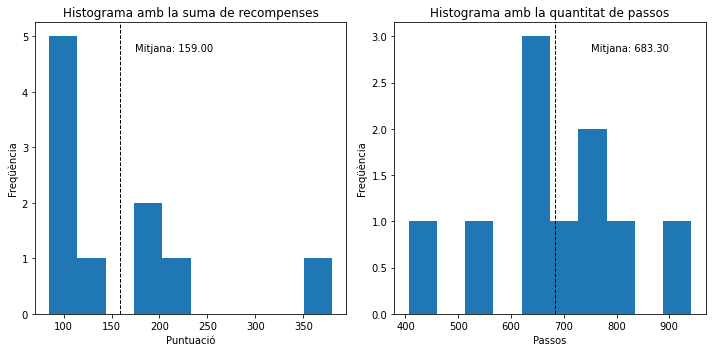

Després de 10 partides la puntuació mitjana és 159.0 amb 683.3 passos de mitjana.


In [7]:
switch_action = {
        0: "NOOP",
        1: "FIRE",
        2: "RIGHT",
        3: "LEFT",
        4: "RIGHTFIRE",
        5: "LEFTFIRE"
    }

games = 1000
if quick_execution:
    games = 10

total_score = np.empty(shape=(games), dtype=int)
total_steps = np.empty(shape=(games), dtype=int)

for i in range(games):
    frames = []
    done = False
    env.reset()
    t=0
    score = 0

    # Jugar una partida aleatòria.
    while not done:
        action = env.action_space.sample()
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, reward, done, info = env.step(action)
        score += reward
        # Imprimir time-step
        t+=1

    total_score[i] = score
    total_steps[i] = t
    
    print("\rEpisode {:d} Reward {:.2f} Steps {:d}\t\t".format(i+1, score, t))
env.close()

#Plots 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.subplot(1,2,1)
# Histograma amb la suma de recompenses de cada partida
plt.hist(total_score)
plt.ylabel("Freqüència")
plt.xlabel("Puntuació")
plt.title("Histograma amb la suma de recompenses")
plt.axvline(total_score.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(total_score.mean()*1.1, max_ylim*0.9, 'Mitjana: {:.2f}'.format(total_score.mean()))

# Histograma amb la quantitat de passos per resoldre cada partida
plt.subplot(1,2,2)
plt.hist(total_steps)
plt.ylabel("Freqüència")
plt.xlabel("Passos")
plt.title("Histograma amb la quantitat de passos")
plt.axvline(total_steps.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(total_steps.mean()*1.1, max_ylim*0.9, 'Mitjana: {:.2f}'.format(total_steps.mean()))

plt.tight_layout()
plt.show()

# Càlcul de mitjanes
print("Després de {} partides la puntuació mitjana és {} amb {} passos de mitjana.".format(games, np.average(total_score), np.average(total_steps)))




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>1.4 Anàlisi (0.3 pts):</strong> Quina és la mitjana de recompenses obtinguda? I la mitjana de passos per episodi? Comenta els resultats obtinguts.
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució:</strong>
<br>Observem que la distribució dels 2 histogrames és smimilar concentrant la major part dels resultats a la banda esquerra. Significa que les partides duren poc i obtenen poca puntuació donat que l'agent juga de forma erràtica. Només en aquells casos que té sort aconsegueix sobreviure més temps i obtenir més puntuació. Per això veiem un decreixement exponencial per la part dreta dels histogrames.<br>
</div>

## 2. Agent DQN (2.8 pts)
En aquest apartat implementarem una solució DQN per intentar obtenir un model que ens permeti solucionar aquest entorn. Primer definirem el model de xarxa neuronal, després descriurem el comportament de l'agent, l'entrenarem i, finalment, testejarem el funcionament de l'agent entrenat.

### 2.1 Processament de les observacions.


El primer pas és entendre l'estructura de la informació que ens proporciona l'entorn. Els jocs d'Atari utilitzen un espai d'observacions amb una estructura de la forma següent (210, 160, 3), és a dir, 210 píxels d'amplada, 160 d'alçada i 3 colors (RGB). Cadascun d'aquests punts de l'estructura és un píxel de color i té un rang de valors que van des del 0 fins a 255, cosa que ens dóna $256^{(210x160x3)}$ = $256^{100800}$ possibilitats (a mode de comparació, tenim aproximadament $10^{80}$ àtoms a l'univers observable)

<p></p>
<img src="imatges/atomos.jpg"  width="1000">

Font: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.1 Anàlisi (0.2 pts):</strong> És possible implementar una solució tabular vista durant la PAC1 en aquest entorn de Space Invader? Per què?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Resposta:</strong>
<br>Les solucions tabulars requereixen emmagatzemar cada estat al sistema. Això no és possible a la pràctica donat l'elevat nombre d'estats del problema que podem considerar infinits des d'un punt de vista pràctic.<br>
</div>

En aquest cas, la millor idea és, atès un estat, aproximar els valors Q per a cada possible acció en aquest estat. És a dir, implementarem la solució que pots observar a la figura següent.

<p></p>
<img src="imatges/deep.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<p></p>

Ara bé, al joc Space Invader no tot l'espai té utilitat. El marcador, el marc o la quantitat de vides no és necessari per al desenvolupament del joc. Una pràctica molt habitual en l'aprenentatge per reforç és reduir les dimensions de l'entorn amb l'objectiu de disminuir la quantitat de càlculs necessaris per obtenir un model útil per a l'entorn.

Exactament, per a aquesta PAC us demanarem reduir l'espai dels frames a 84 x 84 píxels, reduir els nostres 3 canals de color (RGB) a 1 (escala de grisos), normalitzar el resultat i, finalment, emmagatzemar els 4 últims frames com es mostra a la figura següent:
<p></p>
<img src="imatges/preprocessing.jpg"  width="1000">

Font: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.2 Exercici (0.1 pts):</strong> Defineix el mètode 'scale_lumininance' per, donat un estat, transformar els punts del sistema RGB al sistema d'escala de grisos.
</div>

In [8]:
def scale_luminance(obs):
    '''
    Paràmetres:
        obs: Observació de l'entorn corresponent a una imatge RGB ndarray (210, 160, 3)        
    Retorn:
        obs: Observació de l'entorn corresponent a una imatge en escala de grisos ndarray (210, 160)        
    '''
    ####### TODO #######
    return np.array(Image.fromarray(obs).convert('L'))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.3 Exercici (0.1 pts):</strong> Defineix el mètode 'resize' per, donat un estat, redimensionar la seva mida a 84*84
</div>

In [9]:
def resize(obs):
    '''
    Paràmetres:
        obs: Observació de l'entorn corresponent a una imatge en escala de grisos ndarray (210, 160)        
    Retorn:
        obs: Observació de l'entorn corresponent a una imatge en escala de grisos trasnsformada a ndarray (84, 84)        
    '''
    ####### TODO #######
    newsize = (84, 84)
    return np.array(Image.fromarray(obs).resize(newsize))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.4 Exercici (0.1 pts):</strong> Defineix el mètode 'normalize' per, donat un estat, normalitzar la imatge
</div>

In [10]:
def normalize(obs):
    '''
    Paràmetres:
        obs: Observació de l'entorn corresponent a una imatge en escala de grisos ndarray (84, 84)    
    Retorn:
        obs: Observació de l'entorn corresponent a una imatge en escala de grisos trasnsformada a ndarray (84, 84) i normalitzada        
    '''
    ####### TODO #######
    return obs/255

El resultat que obtindràs serà el següent:
<p></p>
<table  border="0">
<thead>
  <tr style='border:none;' >
    <th style='border:none;' ><img src="imatges/preprocess_grey.png"  width="500"></th>
    <th style='border:none;'><img src="imatges/preprocess_normalize.png"  width="500"></th>
    <th style='border:none;' ><img src="imatges/preprocess_size.png"  width="500"></th>
  </tr>
</thead>
<tbody>
  <tr style='border:none;'>
    <td style='text-align: center; border:none;'> 1.scale_luminance(obs) </td>
    <td style='text-align: center; border:none;'> 2.resize(obs) </td>
    <td style='text-align: center; border:none;'> 3.normalize(obs)</td>
  </tr>
</tbody>
</table></div>

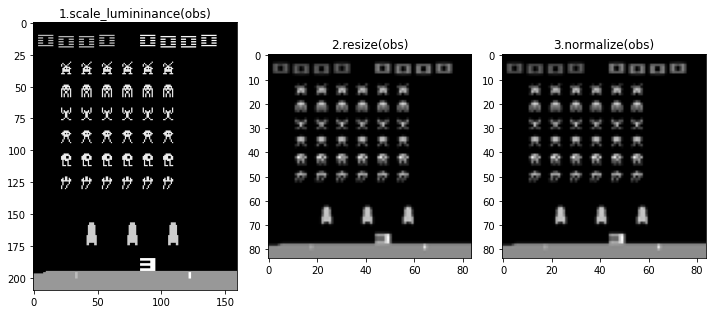

In [11]:
# Provem les funcions
obs_2_2 = scale_luminance(env.reset())
obs_2_3 = resize(obs_2_2)
obs_2_4 = normalize(obs_2_3)

#Plots 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(obs_2_2, cmap="gray")
plt.title("1.scale_lumininance(obs)")

plt.subplot(1,3,2)
plt.imshow(obs_2_3, cmap="gray")
plt.title("2.resize(obs)")

plt.subplot(1,3,3)
plt.imshow(obs_2_4, cmap="gray")
plt.title("3.normalize(obs)")

plt.tight_layout()


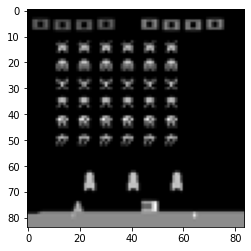

In [12]:
env.render(mode='rgb_array')
action = env.action_space.sample()
state, reward, done, _ = env.step(action)

# Funció que realitza tot el pre-processament d'una observació
def preprocess_observation(obs):
    obs_proc = scale_luminance(obs)
    obs_proc = resize(obs_proc)
    obs_proc = normalize(obs_proc)
    return obs_proc

# Mostrem la imatge
plt.imshow(preprocess_observation(state), cmap="gray")
plt.show()

Per últim, com interpretem el moviment? Les imatges corresponen a informació estàtica de les partides i, en aquest entorn, és important conèixer la direcció del tret o el moviment dels invasors. Per això, una forma de gestionar aquesta informació és apilant fotogrames per poder proporcionar a l'algorisme informació sobre la progressió de la partida.


Utilitzem un exemple molt clar, el Ping Pong:
<p></p>
<img src="imatges/temporal-limitation-2.png"  width="1000">

Fixa't com la pilota es desplaça cap a la dreta. L'agrupació dels frames ens permet traslladar la informació espacial al nostre algorisme.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.5 Exercici (0.1 pts):</strong> Implementa la funció stack_frame per apilar 4 frames duna partida. Aquesta funció ha d'apilar inicialment (quan is_new = True) el mateix frame 4 vegades per, posteriorment, conforme es vagin introduint nous frames anar substituint els més antics.
</div>

In [13]:
def stack_frame(stacked_frames, frame, is_new):
        """Stacking Frames.
        Params
        ======
            stacked_frames (array): array de frames (al retornar-lo ha de contenir 4 frames)
            frame: Nova imatge per a afegir a l'array (s'ha d'esborrar la més antiga)
            is_new: Primera vegada que s'utilitza l'array.
        """
        #### TODO ####
        # Preprocessem la imatge
        frame = preprocess_observation(frame)
        size = 4
        if (is_new):
            stacked_frames = np.empty(shape=(size,84,84))
            for i in range(size):
                #Apilem 4 cops el frame
                stacked_frames[i] = frame
        else:
            for i in range(size-1):
                #Shiftem els frames
                stacked_frames[i]=stacked_frames[i+1]
            # Agefim el frame més recent a la posició 3
            stacked_frames[size-1] = frame            
                
        return stacked_frames

Un cop creada la funció la testegem jugant una partida, emmagatzemant els 4 frames més recents a cada pas, i finalment mostrem els 4 últims frames de la partida.

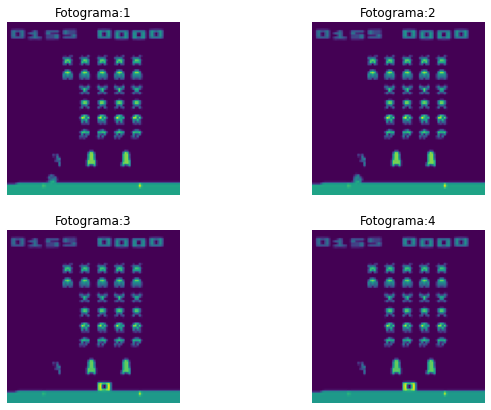

In [14]:
# Omplim 'state_stack' amb 4 còpies idèntiques del frame inicial de la partida
state_stack= stack_frame(None, env.reset(), True)

# Juguem una partida aleatòria i anem actualitzant els 4 frames de 'state_stack'
# conforme es van produint de nous
while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    state_stack = stack_frame(state_stack, next_state, False)

    if done:
         break

# Mostrem els darrers 4 frames de la partida que han quedat enmagatzemats a 'state_stack'
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cont=1

for i in state_stack:
    fig.add_subplot(rows, columns, cont)
    plt.imshow(i)
    plt.axis('off')
    plt.title('Fotograma:' + str(cont))
    cont = cont +1

Ara amb aquestes modificacions podem passar al següent punt, la creació de la Xarxa
<p></p>
<img src="imatges/deep-q-network.jpg"  width="1000">

Font: <href>https://huggingface.co/blog/deep-rl-dqn</href>

Com s'observa a la imatge, farem servir un model convolucional (perfecte per detectar patrons en imatges) juntament amb un sistema lineal completament connectat. Per a la xarxa convolucional us proposem la següent configuració:

<ul>
    <li>Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=4, out_channels=32, kernel_size=8, stride=4 amb activació ReLU.</li>
    <li>Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.</li>
    <li>Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.</li>
</ul>

El resultat d'aquesta primera xarxa (3D) el connectarem amb un model complementament connectat (1D) amb la següent estructura lineal:

* Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU
* Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible).

Finalment, farem servir l'optimitzador Adam per entrenar la xarxa.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>2.6 Exercici (0.5 pts): </strong>Implementar la classe <code>DQN_CNN()</code>. Inicialitzar les variables necessàries i definir el model CNN i lineal indicat.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>

In [15]:
import torch.nn as nn
class DQN_CNN(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super(DQN_CNN, self).__init__()
        """
        Params
        ======
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'acciones possibles
        device: cpu o cuda
        red_cnn: definició de la xarxa convolucional
        red_lineal: definició de la xarxa lineal
        """
        #######################################
        ###TODO: inicialització i model ###
        self.input_shape = state_stack.shape
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        #######################################
        ##TODO: Construcció de la xarxa neuronal convolucional
        self.red_cnn =torch.nn.Sequential(
            # Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=4, out_channels=32, kernel_size=8, stride=4 amb activació ReLU.
            torch.nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            # Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            # Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            torch.nn.ReLU()           
            )

        if torch.cuda.is_available():
            self.red_cnn.cuda()

        #######################################
        ##TODO: Construcció de la xarxa neuronal lineal completament connectada
        self.fc_layer_inputs = self.feature_size()
        self.red_lineal = torch.nn.Sequential(
            # Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU
            torch.nn.Linear(self.fc_layer_inputs, 512),
            torch.nn.ReLU(),
            # Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible).
            torch.nn.Linear(512, self.n_outputs)
        )


        if torch.cuda.is_available():
            self.red_lineal.cuda()

        #######################################
        ##TODO: Inicialitzar l'optimitzador
        self.optimizer = torch.optim.Adam(self.parameters())

    ### Mètode e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            #print("Get Action")
            qvals = self.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        #print("DQN get_qvals state shape {}".format(state.shape))
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)
        return self.red_lineal(cnn_out)


    def feature_size(self):
        return self.red_cnn(autograd.Variable(torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)



Definim la classe per al *buffer* de repetició d'experiències:

In [16]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Ús de l'operador asterisc per desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### 2.2 Definició de l'agent


A continuació, implementarem una classe que defineixi l'entrenament de l'agent tenint en compte:
     <ul>
         <li>L'exploració/explotació (decaïment d'epsilon)</li>
         <li>L'actualització i sincronització de la xarxa principal i la xarxa objectiu (pèrdua)</li>
     </ul>

A més, considerarem que l'agent ha superat l'entorn quan obtingui una puntuació superior a 350 en 100 partides

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.7 Exercici (1 pt):</strong> Implementar els punts següents de la classe <code>DQNAgent()</code>:
    <ol>
        <li>Declarar les variables de la classe</li>
        <li>Inicialitzar les variables necessàries</li>
        <li>Implementar l'acció que cal prendre</li>
        <li>Actualitzar la xarxa principal segons la freqüència establerta als hiperparàmetres</li>
        <li>Calcular l'equació de Bellman</li>
        <li>Sincronitzar la xarxa objectiu segons la freqüència establerta als hiperparàmetres</li>
        <li>Calcular la mitjana de recompenses dels darrers 100 episodis</li>
        <li>Actualitzar epsilon segons: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01)$$ </li>
    </ol>
A més, durant el procés s'han d'emmagatzemar (*):
    <ul>
        <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
        <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
        <li>La pèrdua durant l'entrenament</li>
        <li>L'evolució d'epsilon durant l'entrenament</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>, excepte en quin moment emmagatzemar les variables que s'indiquen a (*).
</div>

In [17]:
from copy import deepcopy, copy
class DQNAgent:
    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold = 350, # Llindar de l'entorn = 350
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100): # Episodis per a fer la mitjana = 100 
        """"
        Params
        ======
        env: entorn
        main_network: classe amb la xarxa neuronal dissenyada
        target_network: xarxa objectiu
        buffer: classe amb el buffer de repetició d'experiències
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloc dels X darrers episodis dels quals es calcularà la mitjana de recompensa
        reward_threshold: llindar de recompensa
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # xarxa objectiu (còpia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock # bloc dels X últims episodis dels quals es calcularà la mitjana de recompensa. Valor definit per defete a 100
        self.reward_threshold = reward_threshold # Llindar. Valor definit per defecte a 350
        self.initialize()

    ###################################################################
    #####TODO 2: inicialitzar variables extra que són necessàries######
    def initialize(self):
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        incio_juego = preprocess_observation(self.env.reset())
        self.state0 = stack_frame(None, incio_juego, True)
        self.update_loss = []           # Emmagatzema el loss de cada episodi
        self.training_rewards = []      # Emmagatzema les puntuacions
        self.mean_training_rewards = [] # Emmagatzema les puntuacions mitjanes
        self.epsilon_all=[]             # Emmagatzema el valor d'epsilon
        self.loss_all=[]                # Emmagatzema el loss al final de cada episodi

    #################################################################################
    ######TODO 3: Prendre una nova acció ############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acció aleatòria al burn-in
        else:
            action = self.main_network.get_action(self.state0, eps)# acció a partir del valor de Q (elecció de l'acció amb millor Q)
            self.step_count += 1

        #TODO: Realització de l'acció i obtenció del nou estat i la recompensa.
        new_state, reward, done, _ = self.env.step(action) ###3  
        new_state =  stack_frame(self.state0, new_state, False) ###3 # Recordar preprocessar els estats 
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiència al buffer
        self.state0 = new_state

        #TODO: resetejar entorn 'if done'
        if done:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True) # Recordar preprocessar els estats
        return done



    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Omplim el buffer amb N experiències aleatòries ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        maximo = 0
        while training:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True) ###3 # Recordar preprocessar els estats
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                ####TODO 4: Actualitzar xarxa principal segons la freqüència establerta #########
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronitzar xarxa principal i xarxa objectiu segons la freqüència establerta
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Emmagatzemar epsilon, training rewards i loss#######
                    self.training_rewards.append(self.total_reward) # guardem les recompenses obtingudes                    
                    if len(self.update_loss)>0:
                        self.loss_all.append(self.update_loss[len(self.update_loss)-1])
                    else:
                        self.loss_all.append(0)
                    self.epsilon_all.append(self.epsilon) # guardem tots els valors d'epsilon
                    
                    ##################################################################
                    
                    self.update_loss = []


                    #######################################################################################
                    ###TODO 7: calcular la mitjana de recompensa dels últims X episodis, i emmagatzemar####
                    mean_rewards = np.mean(   # calculem la mitjana de recompensa dels últims X episodis
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    
                    ##################################################################

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Maxim {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo))

                    if episode%100 == 0:
                        # Cada 100 episodis mostrem l'estat i guardem el model 
                        # Guardem els pesos
                        try:
                            os.makedirs('models')
                        except:
                            pass
                        dateLabel = datetime.now().strftime("%Y%m%d%H%M%S") + " - "
                        # Guardem els pesos
                        torch.save(self.main_network.state_dict(), "./models/{}agentDQN_Trained_Model_dqn_cnn_E_{}_R_{}.pth".format(dateLabel, episode, mean_rewards))
                    
                    # Comprovar si s'ha arribat al màxim d'episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    # i s'ha entrenat un mínim d'episodis
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualitzar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)


    ####################################
    ####TODO 5: Càlcul de la pèrdua ####
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenim els valors de Q de la xarxa principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenim els valors de Q de la xarxa objectiu
        # El paràmetre detach() evita que aquests valors actualitzin la xarxa objectiu
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estats terminals

        #################################################################################
        ###TODO: Calcular l'equació de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals


        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss


    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch)# calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.main_network.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Guardem els valors de pèrdua
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

### 2.3 Entrenament
A continuació entrenarem el model amb els següents hiperparàmetres:
   <ul>
        <li>Velocitat d'aprenentatge: 0.001 </li>
        <li>Mida del batch: 32</li>
        <li>Capacitat màxima del buffer: 8000</li>
        <li>Gamma: 0.99</li>
        <li>Epsilon: 1, amb decaïment de 0.995 amb un mínim de 0.01</li>
        <li>Nombre d'experiències per emplenar inicialment el buffer: 100</li>
        <li>Nombre màxim d'episodis: 5000</li>
        <li>Nombre mínim d'episodis: 250</li>
        <li>Freqüència d'actualització de la xarxa neuronal: 100 </li>
        <li>Freqüència de sincronització amb la xarxa objectiu: 5000</li>
    </ul>

És probable que amb els hiperparàmetres proposats no s'arribi a solucionar l'entorn (aconseguir una puntuació de 350 a la mitjana de 100 partides). L'objectiu principal és millorar els resultats de l'agent aleatori.

Està permès realitzar modificacions als paràmetres presentats encara que, el darrer exercici d'aquesta PAC, consisteix a millorar els resultats obtinguts amb aquest entrenament. Per tant, encara que sigui permès, no és recomanable.

Si l'alumne no disposa de temps suficient pot escurçar el temps d'entrenament fixant el nombre màxim d'episodis = 3000 en lloc dels 5000 proposats.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.8 Exercici (0.1 pts):</strong> Declarar els hiperparàmetres, carregueu el model de xarxa neuronal i entreneu l'agent
</div>

In [18]:
lr = 0.001            #Velocitat d'aprenentatge (alpha)
BATCH_SIZE = 32       #Conjunt a agafar del buffer per a la xarxa neuronal
MEMORY_SIZE = 8000    #Màxima capacitat del buffer
GAMMA = 0.99          #Valor gamma de l'equació de Bellman
EPSILON = 1           #Valor inicial d'epsilon
BURN_IN = 100         #Nombre d'episodis inicials usats per emplenar el buffer abans d'entrenar
MAX_EPISODES = maxepisodes   #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)
EPSILON_DECAY = .995  #Decaïment d'epsilon
DNN_UPD = 100         #Freqüència d'actualització de la xarxa neuronal 
DNN_SYNC = 5000       #Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

if quick_execution:
    MAX_EPISODES = max_quick_episodes_DQN    #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
    MIN_EPISODES = 10    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)

buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

dqn = DQN_CNN(env, learning_rate=lr)

agent = DQNAgent(env, main_network=dqn, buffer=buffer, reward_threshold=350, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE, nblock=100)

agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, min_episodios=MIN_EPISODES)

Filling replay buffer...
Training...
Episode 1 Mean Rewards 120.00 Epsilon 1 , Maxim 0.00		
Episode 2 Mean Rewards 177.50 Epsilon 0.995 , Maxim 0.00		
Episode 3 Mean Rewards 178.33 Epsilon 0.990025 , Maxim 0.00		
Episode 4 Mean Rewards 186.25 Epsilon 0.985074875 , Maxim 0.00		
Episode 5 Mean Rewards 234.00 Epsilon 0.9801495006250001 , Maxim 0.00		
Episode 6 Mean Rewards 217.50 Epsilon 0.9752487531218751 , Maxim 0.00		
Episode 7 Mean Rewards 207.86 Epsilon 0.9703725093562657 , Maxim 0.00		
Episode 8 Mean Rewards 187.50 Epsilon 0.9655206468094844 , Maxim 0.00		
Episode 9 Mean Rewards 186.67 Epsilon 0.960693043575437 , Maxim 0.00		
Episode 10 Mean Rewards 172.50 Epsilon 0.9558895783575597 , Maxim 0.00		
Episode 11 Mean Rewards 161.82 Epsilon 0.9511101304657719 , Maxim 0.00		
Episode 12 Mean Rewards 163.33 Epsilon 0.946354579813443 , Maxim 0.00		
Episode 13 Mean Rewards 169.23 Epsilon 0.9416228069143757 , Maxim 0.00		
Episode 14 Mean Rewards 163.21 Epsilon 0.9369146928798039 , Maxim 0.00		

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.9 Exercici (0.1 pts):</strong> Representar:
    <ol>
        <li>Gràfic amb les recompenses obtingudes al llarg de l'entrenament, l'evolució de les recompenses mitjanes i el llindar de recompensa establert per l'entorn.</li>
        <li>Gràfic amb l'evolució de la pèrdua al llarg de l'entrenament</li>
        <li>Gràfic amb l'evolució d'epsilon durant l'entrenament</li>
    </ol>
</div>

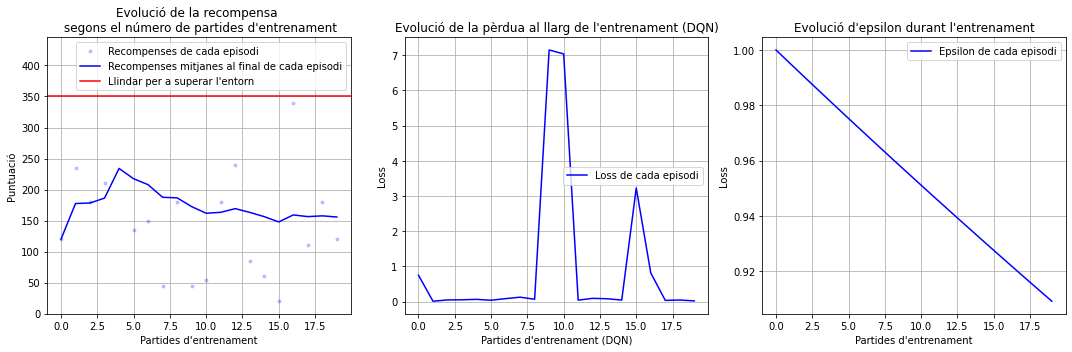

In [19]:

# Preparem els valors de loss
loss_all_list = []
for i in range(len(agent.loss_all)):
    loss_all_list.append(float(agent.loss_all[i]))

#Plots 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(len(agent.training_rewards)), agent.training_rewards, 'b.', label='Recompenses de cada episodi', alpha=0.2)
plt.plot(range(len(agent.mean_training_rewards)), agent.mean_training_rewards, '-b', label='Recompenses mitjanes al final de cada episodi')
plt.axhline(y=agent.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
plt.xlabel("Partides d'entrenament")
plt.ylabel("Puntuació")
plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament")
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(range(len(loss_all_list)), loss_all_list, '-b', label='Loss de cada episodi')
plt.xlabel("Partides d'entrenament (DQN)")
plt.ylabel("Loss")
plt.title("Evolució de la pèrdua al llarg de l'entrenament (DQN)")
plt.grid()
plt.legend()

plt.subplot(1,3,3)
plt.plot(range(len(agent.epsilon_all)), agent.epsilon_all, '-b', label='Epsilon de cada episodi')
plt.xlabel("Partides d'entrenament")
plt.ylabel("Loss")
plt.title("Evolució d'epsilon durant l'entrenament")
plt.grid()
plt.legend()


plt.tight_layout()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>2.10 Exercici (0.1 pts):</strong> Comenta els resultats
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució:</strong>
https://github.com/hsuanchuu/2019Playing-Space-Invaders-with-Deep-Q-Networks
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>2.11 Exercici (0.1 pts):</strong> Guardar el model entrenat en format ".pth" amb el nom "agentDQN_Trained_Model_dqn_cnn.pth".
</div>

In [20]:
# Guardem el model sencer
torch.save(dqn, "./models/{}agentDQN_Trained_Model_dqn_cnn-FULL.pth".format(Label))

# Guardem els pesos
torch.save(dqn.state_dict(), "./models/{}agentDQN_Trained_Model_dqn_cnn.pth".format(Label))

# Salvem agent i els seus arrays de rewards
np.savetxt("./models/{}agentDQN_Trained_Model_dqn_cnn-MeanRewards.txt".format(Label), agent.mean_training_rewards, fmt='%d')
np.savetxt("./models/{}agentDQN_Trained_Model_dqn_cnn-Rewards.txt".format(Label), agent.training_rewards, fmt='%d')



### 2.4 Test de l'agent entrenat

Un cop entrenat l'agent, ens interessa comprovar com ha après de bé, si el "robot" és capaç de realitzar les tasques apreses. Per això, recuperem el model entrenat i deixem que l'agent prengui accions segons aquest model i n'observem el comportament.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.12 Exercici (0.2 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 20 episodis consecutius. Calcular la suma de recompenses per a cada episodi. Mostrar en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn.
</div>

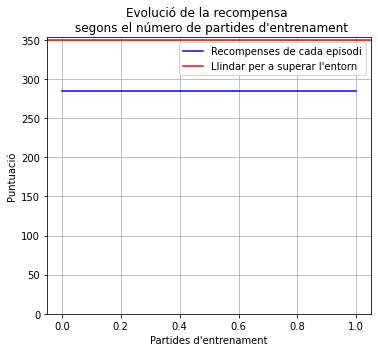

In [21]:
agent.main_network.load_state_dict(torch.load("./models/{}agentDQN_Trained_Model_dqn_cnn.pth".format(Label)))

# Definim una funció genèrica que executi diferents partides amb l'agent entrenat 
def save_agent_n_games(env, ag, games = 1):
    '''
    :param env:  entorn GYM
    :param ag:  agent entrenat
    :games: número de partides
    :return:
    :comentaris: Si s'indica un nom de fitxer es guarda la primera partida. En cas contrari, calcula la suma de recompenses per a cada episodi 
    i mostra en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn.
    '''
    
    # Guardem passes i recompenses
    total_score = np.empty(shape=(games), dtype=int)

    for i in range (games):
        env.reset()
        observation = env.reset()
        incio_juego = preprocess_observation(observation)
        state= stack_frame(None, incio_juego, True)
        total_reward = 0
        t=0
        while True:
                state= stack_frame(state, preprocess_observation(observation), False)
                # Salvem la primera partida si s'indica
                action = ag.main_network.get_action(state,epsilon=0.0)
                observation, reward, done, info = env.step(action)
                total_reward += reward
                t=t+1
                if done:
                    break

        total_score[i] = total_reward
        #print("\rEpisode {:d} Rewards {:.2f} Frames {:d} Steps {:d}".format(i, total_reward, len(frames), t))

    env.close()
    
    # Generem el gràfic
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(range(len(total_score)), total_score, '-b', label='Recompenses de cada episodi')
    plt.axhline(y=350, color='r', linestyle='-', label="Llindar per a superar l'entorn")
    plt.xlabel("Partides d'entrenament")
    plt.ylabel("Puntuació")
    plt.ylim(bottom=0)
    plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament")
    plt.grid()
    plt.legend()
    plt.tight_layout()

games = 20
if quick_execution:
    games=2

save_agent_n_games(env, agent, games=games)



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.13 Anàlisi (0.1 pts):</strong> Emmagatzema una partida d'exemple de l'agent a la carpeta vídeos en format GIF per poder visualitzar-ne el comportament (es dóna el codi fet) i comenta el comportament de l'agent entrenat.
</div>

In [22]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

# Funció per a jugar i enmagatzemar una partida en format GIF amb un agent entrenat
def save_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorn GYM
    :param ag:  agent entrenat
    :param nombre_fichero:  nom del fitxer
    :return:
    '''
    frames = []
    env.reset()
    observation = env.reset()
    incio_juego = preprocess_observation(observation)
    state= stack_frame(None, incio_juego, True)
    total_reward = 0
    t=0
    while True:
            state= stack_frame(state, preprocess_observation(observation), False)
            frame = env.render(mode='rgb_array')
            frames.append(_label_with_text(frame))
            action = ag.main_network.get_action(state,epsilon=0.0)
            observation, reward, done, info = env.step(action)
            total_reward += reward
            t=t+1
            if done:
                break

    env.close()
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)

# Juguem i enmagatzemem una partida amb l'agent entrenat 
save_agent_gif(env,agent, 'agent_dqn.gif')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Resposta (comentaris):</strong>
<br><br>

</div>


Pot ser que el resultat sigui molt semblant al següent GIF. No us preocupeu, amb els paràmetres escollits és difícil obtenir un millor rendiment.

![title](videos/space_invader_dqn_comportamiento_continuo.gif)

## 3. Agent Dueling DQN (2.2 pts)

En aquest apartat resoldrem el mateix entorn amb les mateixes característiques per a l'agent, però usant una dueling DQN. Com en el cas anterior, primer definirem el model de xarxa neuronal, després descriurem el comportament de l'agent, l'entrenarem i, finalment, en testejarem el funcionament.

### 3.1 Definició de l'arquitectura de la xarxa neuronal


L'objectiu principal de les dueling DQN és "estalviar-se" el càlcul del valor de Q en aquells estats on és irrellevant l'acció que es prengui. Per això es descompon la funció Q en dos components:


$$Q(s, a) = A(s, a) + V (s)$$


Aquesta descomposició es fa a nivell de l'arquitectura de la xarxa neuronal. Les primeres capes que teníem a la DQN seran comuns, i després la xarxa es dividirà en dues parts separades definides per la resta de capes.

La descomposició en subxarxes del model de la DQN implementada a l'apartat anterior serà llavors:
<ol>
     <li>Bloc comú, la xarxa CNN</li>
     <li>Xarxa advantage A(s,a):</li>
          <ul>
              <li>Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU</li>
              <li>Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, el nombre de neurones de sortida dependrà del tipus de xarxa, A(s,a) en aquest cas, i tindrà tantes neurones com dimensions tingui l'espai d'accions.</li>
              </ul>
     <li>Xarxa value V(s):</li>
             <ul>
              <li>Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU</li>
              <li>Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida amb un valor per estat.</li>
              </ul>
</ol>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.1 Exercici (0.75 pts):</strong> Implementar la classe <code>duelingDQN()</code>. Inicialitzar les variables necessàries i definir el model de xarxa neuronal indicat.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>

In [23]:
# https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751

class duelingDQN(torch.nn.Module):
    ###################################
    ###TODO: inicialització i model ###
    def __init__(self, env, learning_rate=1e-3):
        """
        Params
        ======
        input_shape: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'accions possibles
        device: cpu o cuda
        red_cnn: definició de la xarxa convolucional
        value: definició de la xarxa neuronal value
        advantage: definició de la xarxa neuronal advantage
        """
        ###################################
        ###TODO: Inicialitzar variables####
        super(duelingDQN, self).__init__()
        self.input_shape = state_stack.shape
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
        ########################################
        ##TODO: Construcció de la xarxa neuronal
        self.red_cnn =torch.nn.Sequential(
            # Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=4, out_channels=32, kernel_size=8, stride=4 amb activació ReLU.
            torch.nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            # Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            # Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            torch.nn.ReLU()           
            )

        if torch.cuda.is_available():
            self.red_cnn.cuda()
        self.fc_layer_inputs = self.feature_size()
        self.advantage = torch.nn.Sequential(
            # Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU
            torch.nn.Linear(self.fc_layer_inputs, 512),
            torch.nn.ReLU(),
            # Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible).
            torch.nn.Linear(512, self.n_outputs)
        )

        self.value = torch.nn.Sequential(
            # Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, amb activació ReLU
            torch.nn.Linear(self.fc_layer_inputs, 512),
            torch.nn.ReLU(),
            # Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida amb un valor per estat.
            torch.nn.Linear(512, 1)
        )

        ### S'ofereix l'opció de treballar amb cuda
        if self.device == 'cuda':
            self.value.cuda()
            self.advantage.cuda()
        self.fc_layer_inputs = self.feature_size()
        
        ### Inicialitzem l'optimitzador
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    #######################################
    #####TODO: funció forward#############
    def forward(self, x):
        #print(x.shape)
        features = self.red_cnn(x)
        features = features.view(features.size(0), -1)
        
        try:
            # Cas de loss amb el batch de 32
            values = self.value(features)  
        except:
            # Cas de next step
            features = features.view(1, -1)
            values = self.value(features)
            
        advantages = self.advantage(features)
        qvals = values + (advantages - advantages.mean())
        # Sostraiem l'avantatja mitjana de totes les accions possibles en aquest estat
        return qvals

    ### Métode e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acció aleatòria
        else:
            #print("get_action state shape {}".format(state.shape))
            qvals = self.get_qvals(state)  # acció a partir del càlcul del valor de Q per a aquesta acció
            action= torch.max(qvals, dim=-1)[1].item()
        return action

    def get_qvals(self, state):
        if type(state) is tuple:
            #print("Is tuple")
            state = np.array(state)
        #print("get_qvals shape {}".format(state.shape))
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)


    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)


Per al buffer de repetició d'experiències podem fer servir exactament la mateixa classe 'experienceReplayBuffer' descrita a l'apartat anterior de la DQN.

### 3.2 Definició de l'agent

La diferència entre la DQN i la dueling DQN se centra, com hem vist, a la definició de l'arquitectura de la xarxa. Però el procés d'aprenentatge i actualització és exactament el mateix. Així, podem recuperar la classe implementada a l'apartat anterior, DQNAgent() i reutilitzar-la aquí sota el nom de duelingDQNAgent(). L'únic que cal fer és afegir l'optimitzador entre les variables a declarar i adaptar la funció de pèrdua al format de pytorch.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.2 Exercici (0.5 pts):</strong> Implementar la classe <code>duelingDQNAgent()</code> com la <code>DQNAgent()</code>
<p>
</p>
De nou, durant el procés s'han d'emmagatzemar (*):
     <ul>
         <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
         <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
         <li>La pèrdua durant l'entrenament</li>
         <li>L'evolució d'epsilon durant l'entrenament</li>
     </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>, excepte en quin moment emmagatzemar les variables que s'indiquen a (*).
</div>

In [24]:
class duelingDQNAgent:
 ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network,
                 buffer, reward_threshold=350,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100):
        """"
        Params
        ======
        env: entorn
        main_network: classe amb la xarxa neuronal dissenyada
        target_network: xarxa objectiu
        buffer: classe amb el buffer de repetició d'experiències
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloc dels X darrers episodis dels quals es calcularà la mitjana de recompensa
        reward_threshold: llindar de recompensa definit a l'entorn
        """
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # xarxa objectiu (còpia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock # bloc dels X últims episodis dels quals es calcularà la mitjana de recompensa. Valor definit per defete a 100
        self.reward_threshold = reward_threshold # Llindar. Valor definit per defecte a 350
        self.initialize()

    ###############################################################
    ####TODO 2: inicialitzar variables extra que es necessiten ####
    def initialize(self):
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        incio_juego = preprocess_observation(self.env.reset())
        self.state0 = stack_frame(None, incio_juego, True)
        self.update_loss = []           # Emmagatzema el loss de cada episodi
        self.training_rewards = []      # Emmagatzema les puntuacions
        self.mean_training_rewards = [] # Emmagatzema les puntuacions mitjanes
        self.epsilon_all=[]             # Emmagatzema el valor d'epsilon
        self.loss_all=[]                # Emmagatzema el loss al final de cada episodi


    #################################################################################
    ######TODO 3: Prendre una nova acció ############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acció aleatòria al burn-in
        else:
            action = self.main_network.get_action(self.state0, eps)# acció a partir del valor de Q (elecció de lacció amb millor Q)
            self.step_count += 1

        #TODO: Realització de l'acció i l'obtenció del nou estat i la recompensa
        new_state, reward, done, _ = self.env.step(action) ###3  
        new_state =  stack_frame(self.state0, new_state, False) ###3 # Recordar preprocessar els estats 
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiència al buffer
        self.state0 = new_state.copy()

        #TODO: resetejar entorn 'if done'
        if done:
            self.state0 =stack_frame(None, preprocess_observation(self.env.reset()), True) # Recordar preprocessar els estats
        return done

    ## Entrenament
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Omplim el buffer amb N experiències aleatòries ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        maximo = 0
        while training:
            self.state0 = stack_frame(None, preprocess_observation(self.env.reset()), True) ###3 # Recordar preprocessar els estats
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # L'agent pren una acció
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                #####TODO 4: Actualitzar la xarxa principal segons la freqüència establerta #####
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronitzar xarxa principal i xarxa objectiu segons la freqüència establerta
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Emmagatzemar epsilon, training rewards i loss#######
                    self.training_rewards.append(self.total_reward) # guardem les recompenses obtingudes                    
                    if len(self.update_loss)>0:
                        self.loss_all.append(self.update_loss[len(self.update_loss)-1])
                    else:
                        self.loss_all.append(0)
                    self.epsilon_all.append(self.epsilon) # guardem tots els valors d'epsilon

                    ####
                    self.update_loss = []


                    #######################################################################################
                    ###TODO 7: calcular la mitjana de recompensa dels últims X episodis, i emmagatzemar####
                    mean_rewards = np.mean(   # calculem la mitjana de recompensa dels últims X episodis
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    ###


                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Maxim {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo))

                    if episode%100 == 0:
                        # Cada 100 episodis mostrem l'estat i guardem el model 
                        # Guardem els pesos
                        try:
                            os.makedirs('models')
                        except:
                            pass
                        dateLabel = datetime.now().strftime("%Y%m%d%H%M%S") + " - "
                        # Guardem els pesos
                        torch.save(self.main_network.state_dict(), "./models/{}agentDueling_DQN_Trained_Model_dqn_cnn{}_R_{}.pth".format(dateLabel, episode, mean_rewards))
                    
                    # Comprovar si s'ha arribat al màxim d'episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    # i s'ha entrenat un mínim d'episodis
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualitzar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)


     ## Càlcul de la pèrdua
    def calculate_loss(self, batch):
        # Separem les variables de l'experiència i les convertim a tensors
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.device)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenim els valors de Q de la xarxa principal
        aux = self.main_network.get_qvals(states)
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)

        #DQN update#
        next_actions = torch.max(self.main_network.get_qvals(next_states), dim=-1)[1]
        if self.device == 'cuda':
            next_actions_vals = next_actions.reshape(-1,1).to(
                device=self.device)
        else:
            next_actions_vals = torch.LongTensor(next_actions).reshape(-1,1).to(device=self.device)
        # Obtenim els valors de Q de la xarxa objectiu
        target_qvals = self.target_network.get_qvals(next_states)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()
        #####

        qvals_next[dones_t] = 0 # 0 en estats terminals

        #TODO: Calculem l'equació de Bellman
        expected_qvals = rewards_vals + self.gamma * qvals_next
        
        # Modifiquem la funció de Loss
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
      
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionem un conjunt del buffer
        loss = self.calculate_loss(batch) # calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.main_network.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Desem els valors de pèrdua
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())






### 3.3 Entrenament
A continuació entrenarem el model dueling DQN amb els mateixos hiperparàmetres amb què entrenem la DQN.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.3 Exercici (0.1 pts):</strong> Carregar el model de xarxa neuronal i entrenar l'agent amb els mateixos hiperparàmetres usats per a la DQN
</div>

In [25]:
lr = 0.001            #Velocitat d'aprenentatge (alpha)
BATCH_SIZE = 32       #Conjunt a agafar del buffer per a la xarxa neuronal
MEMORY_SIZE = 8000    #Màxima capacitat del buffer
GAMMA = 0.99          #Valor gamma de l'equació de Bellman
EPSILON = 1           #Valor inicial d'epsilon
BURN_IN = 100        #Nombre d'episodis inicials usats per emplenar el buffer abans d'entrenar
MAX_EPISODES = maxepisodes   #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)
EPSILON_DECAY = .995   #Decaïment d'epsilon
DNN_UPD = 100         #Freqüència d'actualització de la xarxa neuronal 
DNN_SYNC = 5000       #Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

if quick_execution:
    MAX_EPISODES = max_quick_episodes_Duel_DQN    #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
    MIN_EPISODES = 10    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)

buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

dueling_dqn = duelingDQN(env, learning_rate=lr)

agentDueling = duelingDQNAgent(env, main_network=dueling_dqn, buffer=buffer, reward_threshold=350, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE, nblock=100)

agentDueling.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, min_episodios=MIN_EPISODES)

Filling replay buffer...
Training...
Episode 1 Mean Rewards 105.00 Epsilon 1 , Maxim 0.00		
Episode 2 Mean Rewards 105.00 Epsilon 0.995 , Maxim 0.00		
Episode 3 Mean Rewards 130.00 Epsilon 0.990025 , Maxim 0.00		
Episode 4 Mean Rewards 150.00 Epsilon 0.985074875 , Maxim 0.00		
Episode 5 Mean Rewards 131.00 Epsilon 0.9801495006250001 , Maxim 0.00		
Episode 6 Mean Rewards 135.83 Epsilon 0.9752487531218751 , Maxim 0.00		
Episode 7 Mean Rewards 129.29 Epsilon 0.9703725093562657 , Maxim 0.00		
Episode 8 Mean Rewards 134.38 Epsilon 0.9655206468094844 , Maxim 0.00		
Episode 9 Mean Rewards 149.44 Epsilon 0.960693043575437 , Maxim 0.00		
Episode 10 Mean Rewards 172.50 Epsilon 0.9558895783575597 , Maxim 0.00		
Episode 11 Mean Rewards 169.09 Epsilon 0.9511101304657719 , Maxim 0.00		
Episode 12 Mean Rewards 157.92 Epsilon 0.946354579813443 , Maxim 0.00		
Episode 13 Mean Rewards 155.00 Epsilon 0.9416228069143757 , Maxim 0.00		
Episode 14 Mean Rewards 151.43 Epsilon 0.9369146928798039 , Maxim 0.00		

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.4 Exercici (0.2 ptos):</strong> Mostrar els mateixos gràfics que amb la DQN:
     <ol>
         <li>Recompenses obtingudes al llarg de l'entrenament i l'evolució de les recompenses mitjanes cada 100 episodis, juntament amb el llindar de recompensa establert per l'entorn</li>
         <li>Pèrdua durant l'entrenament</li>
         <li>Evolució d'epsilon durant l'entrenament</li>
     </ol>
</div>

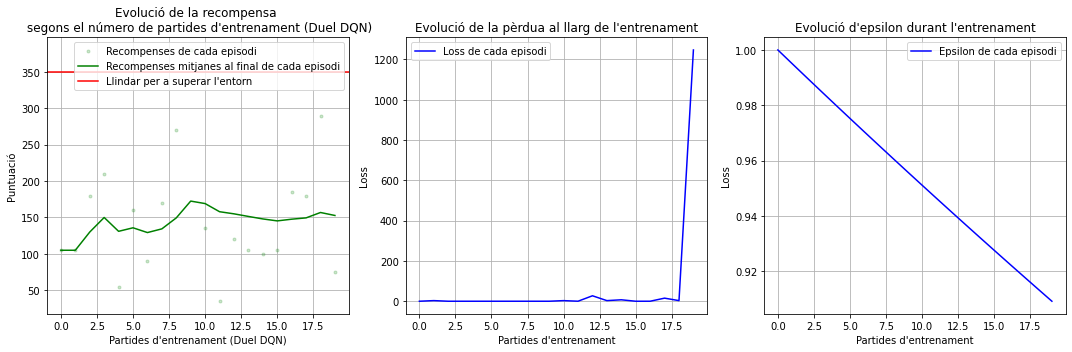

In [26]:

# Preparem els valors de loss
loss_all_list = []
for i in range(len(agentDueling.loss_all)):
    loss_all_list.append(float(agentDueling.loss_all[i]))

#Plots 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(len(agentDueling.training_rewards)), agentDueling.training_rewards, 'g.', label='Recompenses de cada episodi', alpha=0.2)
plt.plot(range(len(agentDueling.mean_training_rewards)), agentDueling.mean_training_rewards, '-g', label='Recompenses mitjanes al final de cada episodi')
plt.axhline(y=agentDueling.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
plt.xlabel("Partides d'entrenament (Duel DQN)")
plt.ylabel("Puntuació")
plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament (Duel DQN)")
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(range(len(loss_all_list)), loss_all_list, '-b', label='Loss de cada episodi')
plt.xlabel("Partides d'entrenament")
plt.ylabel("Loss")
plt.title("Evolució de la pèrdua al llarg de l'entrenament")
plt.grid()
plt.legend()

plt.subplot(1,3,3)
plt.plot(range(len(agentDueling.epsilon_all)), agentDueling.epsilon_all, '-b', label='Epsilon de cada episodi')
plt.xlabel("Partides d'entrenament")
plt.ylabel("Loss")
plt.title("Evolució d'epsilon durant l'entrenament")
plt.grid()
plt.legend()


plt.tight_layout()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.5 Exercici (0.1 pts):</strong> Guardar el model entrenat en format “.pth”.
</div>

In [27]:
# Guardem el model sencer
torch.save(dueling_dqn, "./models/{}agentDueling_DQN_Trained_Model_dqn_cnn-FULL.pth".format(Label))

# Guardem els pesos
torch.save(dueling_dqn.state_dict(), "./models/{}agentDueling_DQN_Trained_Model_dqn_cnn.pth".format(Label))

np.savetxt("./models/{}agentDueling_DQN_Trained_Model_dqn_cnn-MeanRewards.txt".format(Label), agent.mean_training_rewards, fmt='%d')
np.savetxt("./models/{}agentDueling_DQN_Trained_Model_dqn_cnn-Rewards.txt".format(Label), agent.training_rewards, fmt='%d')



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.6 Anàlisi (0.1 pto):</strong> Comenta els resultats obtinguts
</div>

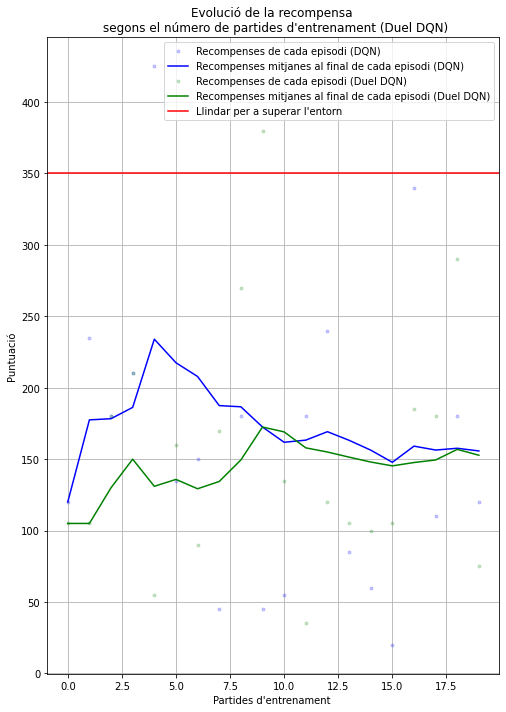

In [28]:
#Plots 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(range(len(agent.training_rewards)), agent.training_rewards, 'b.', label='Recompenses de cada episodi (DQN)', alpha=0.2)
plt.plot(range(len(agent.mean_training_rewards)), agent.mean_training_rewards, '-b', label='Recompenses mitjanes al final de cada episodi (DQN)')
plt.plot(range(len(agentDueling.training_rewards)), agentDueling.training_rewards, 'g.', label='Recompenses de cada episodi (Duel DQN)', alpha=0.2)
plt.plot(range(len(agentDueling.mean_training_rewards)), agentDueling.mean_training_rewards, '-g', label='Recompenses mitjanes al final de cada episodi (Duel DQN)')
plt.axhline(y=agentDueling.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
plt.xlabel("Partides d'entrenament ")
plt.ylabel("Puntuació")
plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament (Duel DQN)")
plt.grid()
plt.legend()
plt.tight_layout()


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br><br>
</div>

### 3.4 Test de l'agent
Finalment, analitzem el comportament de l'agent entrenat.
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.7 Exercici (0.2 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 20 episodis consecutius. Calculeu la suma de recompenses per cada episodi. Mostrar en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn.
</div>

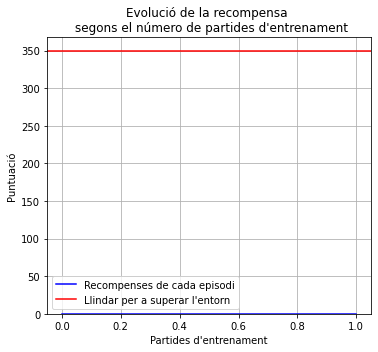

In [29]:
agentDueling.main_network.load_state_dict(torch.load("./models/{}agentDueling_DQN_Trained_Model_dqn_cnn.pth".format(Label)))

# Definim una funció genèrica que execute diferents partides amb l'agent entrenat i salva l'últa partida per a usar en els següents apartats

games = 20
if quick_execution:
    games=2

save_agent_n_games(env, agentDueling, games=games)




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>3.8 Anàlisi (0.25 pts):</strong> Emmagatzema una partida d'exemple de l'agent a la carpeta de vídeos en format GIF per poder visualitzar el seu comportament i comenta el comportament de l'agent entrenat.
</div>

In [30]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
save_agent_gif(env,agentDueling , 'agent_dueling.gif')


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br><br>
</div>

## 4. REINFORCE with baseline (2 pts)

### 4.1 Definició de l'arquitectura de la xarxa neuronal
Utilitzarem un model Seqüencial amb la configuració següent:

<ul>
    <li>Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=4, out_channels=32, kernel_size=8, stride=4 amb activació ReLU.</li>
    <li>Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.</li>
    <li>Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.</li>
</ul>

El resultat d´aquesta primera xarxa el connectarem amb un model complementament connectat amb la següent estructura:

* Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, bias=True i amb activació Tanh
* Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible), bias=True i activació Softmax (dim=-1).

Finalment, farem servir l'optimitzador Adam per entrenar la xarxa.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1 (0.5 ptos):</strong> Implementar la classe <code>PGReinforce()</code>. Inicialitzar les variables necessàries i definir el model Seqüencial de xarxa neuronal indicat.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>.
</div>

In [31]:
class PGReinforce(torch.nn.Module):

    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        """
        Params
        ======
        n_inputs: mida de l'espai d'estats
        n_outputs: mida de l'espai d'accions
        actions: array d'accions possibles
        """
        super(PGReinforce, self).__init__()
         ###################################
        ####TODO: Inicialitzar variables####
        self.input_shape =state_stack.shape
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.device = device
        self.learning_rate = learning_rate
        ######

        ########################################
        ##TODO: Construcció de la xarxa neuronal
        self.red_cnn =torch.nn.Sequential(
            # Una primera capa del tipus Conv2d amb els paràmetres següents in_channels=4, out_channels=32, kernel_size=8, stride=4 amb activació ReLU.
            torch.nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            # Una segona capa del tipus Conv2d amb els paràmetres següents in_channels=32, out_channels=64, kernel_size=4, stride=2 amb activació ReLU.
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            # Una tercera capa del tipus Conv2d amb els paràmetres següents in_channels=64, out_channels=64, kernel_size=3, stride=1 amb activació ReLU.
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            torch.nn.ReLU()           
            )
            
        if self.device == 'cuda':
            self.red_cnn.cuda()


        self.red_lineal = torch.nn.Sequential(
            # Una primera capa completament connectada (representada en pytorch per nn.Lineal) de 512 neurones, bias=True i amb activació Tanh
            torch.nn.Linear(self.feature_size(), 512, bias=True),
            torch.nn.Tanh(),
            # Una darrera capa completament connectada. Aquesta serà la nostra capa de sortida i, per tant, tindrà tantes neurones com dimensions tingui el nostre espai d‟accions (una sortida per cada acció possible), bias=True i activació Softmax (dim=-1).
            torch.nn.Linear(512, self.n_outputs, bias=True),
            torch.nn.Softmax(dim=-1)
        )

        ### S'ofereix l'opció de treballar amb cuda
        if self.device == 'cuda':
            self.red_lineal.cuda()
        self.fc_layer_inputs = self.feature_size()

        #######################################
        ##Inicialitzar l'optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #####

    # Obtenció de les probabilitats de les possibles accions
    def get_action_prob(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        cnn_out = self.red_cnn(state_t).reshape(-1,  self.fc_layer_inputs)
        return self.red_lineal(cnn_out)

    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, * self.input_shape)).to(device=self.device)).view(1, -1).size(1)

### 4.2 Definició de l'agent
<p></p>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.2 Exercici (0.55 pts):</strong> Implementar els punts següents de la classe <code>reinforceAgent()</code>:
<ol>
         <li>Declarar les variables de la classe</li>
         <li>Inicialitzar les variables necessàries</li>
         <li>Implementar l'acció que cal prendre</li>
         <li>Calcular el <i>discounted reward</i> usant com a línia de base la mitjana estandarditzada del retorn
                $$ \frac{x_i - \bar{x}}{\sigma_x}$$</li>
         <li>Calcular la mitjana de recompenses dels últims 100 episodis</li>
         <li>Implementar la pèrdua per actualització</li>
     </ol>
A més, durant el procés s'han d'emmagatzemar (*):
     <ul>
         <li>Les recompenses obtingudes a cada pas de l'entrenament</li>
         <li>Les recompenses mitjanes dels 100 episodis anteriors</li>
         <li>La pèrdua durant l'entrenament</li>
     </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se us proporciona el codi pre-implementat. La implementació que es demana a l'enunciat està indicada als blocs <i>TODO</i> i/o amb variables igualades a <i>None</i>, excepte en quin moment emmagatzemar les variables que s'indiquen a (*).
</div>

In [32]:
class reinforceAgent:

    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, dnnetwork, nblock=100, reward_threshold = 350):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.dnnetwork = dnnetwork
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.initialize()
     #######

    ###############################################################
    ####TODO 2: inicialitzar variables extra que es necessitin ####
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
        self.training_rewards = []      # Emmagatzema les puntuacions
        self.mean_training_rewards = [] # Emmagatzema les puntuacions mitjanes
        self.loss_all=[]                # Emmagatzema el loss al final de cada episodi
        self.update_loss = []
    ######

    ## Entrenament
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size

        episode = 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            incio_juego = preprocess_observation(self.env.reset())
            state0 = stack_frame(None, incio_juego, True)
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False
            t=0
            while gamedone == False:
                t += 1
                ##########################################################
                ######TODO 3: Prendre una nova acció #####################
                action_probs = self.dnnetwork.get_action_prob(state0)  #distribució de probabilitat de les accions donat l'estat actual
                #print(action_probs)
                action = torch.max(action_probs, dim=-1)[1].item()    #acció aleatòria de la distribució de probabilitat
                #print ("Episode {}. Step {}. Action {}".format(episode, t, action))
                next_state, reward, gamedone, _ = self.env.step(action)
                #######


                # Emmagatzemem experiències que es van obtenint en aquest episodi
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                next_state = stack_frame(state0, preprocess_observation(next_state), False)
                state0 = next_state


                if gamedone:
                    episode += 1
                    # Calculem el terme del retorn menys la línia de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.batch_counter += 1

                    #####################################################################################
                    ###TODO 5: calcular mitjana de recompenses dels últims X episodis, i emmagatzemar####
                    self.training_rewards.append(sum(episode_rewards)) # guardem les recompenses obtingudes
                    mean_rewards = np.mean(   # calculem la mitjana de recompensa dels últims X episodis
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    ######

                    # Actualitzem la xarxa quan es completa la mida del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)

                        #######################################
                        ###TODO : emmagatzemar training_loss###
                        if len(self.update_loss)>0:
                            self.loss_all.append(self.update_loss[len(self.update_loss)-1])
                        else:
                            self.loss_all.append(0)
                        ###########

                        self.update_loss = []

                        # Resetejem les variables de l'episodi
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1


                    print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(
                        episode, mean_rewards))
                    
                    if episode%100 == 0:
                        # Cada 100 episodis mostrem l'estat i guardem el model 
                        # Guardem els pesos
                        try:
                            os.makedirs('models')
                        except:
                            pass
                        dateLabel = datetime.now().strftime("%Y%m%d%H%M%S") + " - "
                        # Guardem els pesos
                        torch.save(self.dnnetwork.state_dict(), "./models/{}agentReinforce_Trained_Model_dqn_cnn{}_R_{}.pth".format(dateLabel, episode, mean_rewards))

                    # Comprovem que encara queden episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

    ########################################################
    ###TODO 4: càlcul del retorn menys la línia de base ####
    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = reward_sum - (np.mean(discount_r)/np.std(discount_r))  #Whitening
        return discount_r - baseline
    ##########


    ## Actualizació
    def update(self, batch_s, batch_r, batch_a):
        self.dnnetwork.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)
        action_t = torch.LongTensor(batch_a)
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculem la pèrdua
        loss.backward() # calculem la diferència per obtenir els gradients
        self.dnnetwork.optimizer.step() # apliquem els gradients a la xarxa neuronal
        #Desem els valors de pèrdua
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

    #################################################
    ###TODO 6: Càlcul de la pèrdua ##################
    # Recordatori: cada actualització és proporcional al producte del retorn i el gradient de la probabilitat
    # de prendre l'acció presa, dividit per la probabilitat de prendre aquesta acció (logaritme natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.dnnetwork.get_action_prob(state_t))
        selected_logprobs = reward_t * \
                        logprob[np.arange(len(action_t)), action_t]
        loss = -selected_logprobs.mean()
        return loss
     ########





### 4.3 Entrenament
A continuació entrenarem el model amb els següents hiperparàmetres:
<ul>
     <li>Velocitat d'aprenentatge: 0.005</li>
     <li>Mida del batch: 8</li>
     <li>Gamma: 0.99</li>
     <li>Nombre màxim d'episodis: 5000</li>
</ul>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.3 Exercici (0.2 pts):</strong> Definir els hiperparàmetres, carregar el model de xarxa neuronal i entrenar l'agent.
</div>

In [33]:
lr = 0.005            #Velocitat d'aprenentatge (alpha)
BATCH_SIZE = 8        #Conjunt a agafar del buffer per a la xarxa neuronal
MEMORY_SIZE = 8000    #Màxima capacitat del buffer
GAMMA = 0.99          #Valor gamma de l'equació de Bellman
MAX_EPISODES = maxepisodes   #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
MIN_EPISODES = 250    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)

if quick_execution:
    MAX_EPISODES = max_quick_episodes_Reinforce    #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
    MIN_EPISODES = 10    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)

rnet = PGReinforce(env, learning_rate=lr)

reinforce_agent = reinforceAgent(env,rnet,nblock=100, reward_threshold=350)

reinforce_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=8)

Training...
Episode 1 Mean Rewards 0.00		
Episode 2 Mean Rewards 0.00		
Episode 3 Mean Rewards 0.00		
Episode 4 Mean Rewards 0.00		
Episode 5 Mean Rewards 0.00		
Episode 6 Mean Rewards 0.00		
Episode 7 Mean Rewards 0.00		
Episode 8 Mean Rewards 0.00		
Episode 9 Mean Rewards 0.00		
Episode 10 Mean Rewards 0.00		
Episode 11 Mean Rewards 0.00		
Episode 12 Mean Rewards 0.00		
Episode 13 Mean Rewards 0.00		
Episode 14 Mean Rewards 0.00		
Episode 15 Mean Rewards 0.00		
Episode 16 Mean Rewards 0.00		
Episode 17 Mean Rewards 0.00		
Episode 18 Mean Rewards 0.00		
Episode 19 Mean Rewards 0.00		
Episode 20 Mean Rewards 0.00		

Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.4 Exercici (0.1 pts):</strong> Mostra els gràfics següents:
     <ol>
         <li>Recompenses obtingudes al llarg de l'entrenament i l'evolució de les recompenses mitjanes cada 100 episodis, juntament amb el llindar de recompensa establert per l'entorn</li>
         <li>Pèrdua durant l'entrenament</li>
     </ol>
</div>

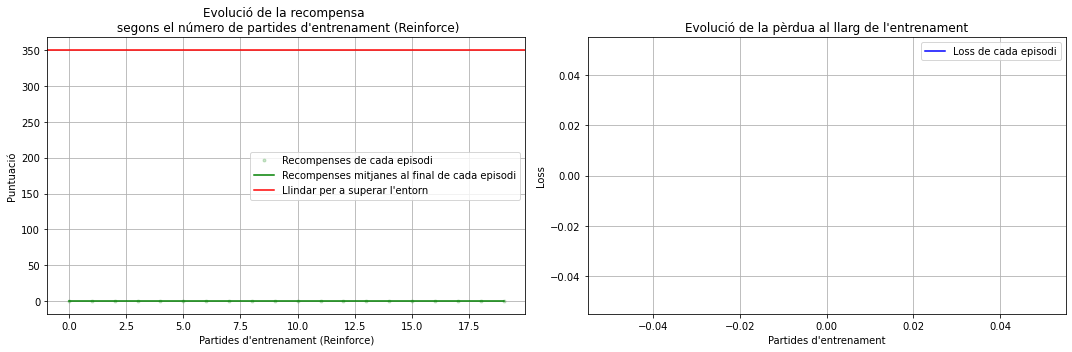

In [34]:
# Preparem els valors de loss
loss_all_list = []
for i in range(len(reinforce_agent.loss_all)):
    loss_all_list.append(float(reinforce_agent.loss_all[i]))

#Plots 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(len(reinforce_agent.training_rewards)), reinforce_agent.training_rewards, 'g.', label='Recompenses de cada episodi', alpha=0.2)
plt.plot(range(len(reinforce_agent.mean_training_rewards)), reinforce_agent.mean_training_rewards, '-g', label='Recompenses mitjanes al final de cada episodi')
plt.axhline(y=reinforce_agent.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
plt.xlabel("Partides d'entrenament (Reinforce)")
plt.ylabel("Puntuació")
plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament (Reinforce)")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(loss_all_list)), loss_all_list, '-b', label='Loss de cada episodi')
plt.xlabel("Partides d'entrenament")
plt.ylabel("Loss")
plt.title("Evolució de la pèrdua al llarg de l'entrenament")
plt.grid()
plt.legend()

plt.tight_layout()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.5 Anàlisi (0.2 ptos):</strong> Guardar el model entrenat en format “.pth” i comentar els resultats obtinguts. Què ha passat amb aquest model?
</div>

In [35]:
# Guardem el model sencer
torch.save(rnet, "./models/{}agentReinforce_Trained_Model-FULL.pth".format(Label))

# Guardem els pesos
torch.save(rnet.state_dict(), "./models/{}agentReinforce_Trained_Model.pth".format(Label))

np.savetxt("./models/{}agentReinforce_Trained_Model-MeanRewards.txt".format(Label), agent.mean_training_rewards, fmt='%d')
np.savetxt("./models/{}agentReinforce_Trained_Model-Rewards.txt".format(Label), agent.training_rewards, fmt='%d')




<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>4.6 Exercici (0.15 pts):</strong> Carregar el model entrenat i executar l'agent entrenat durant 20 episodis consecutius. Calculeu la suma de recompenses per cada episodi. Mostrar en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn. Comentar-ne els resultats.
<p>Emmagatzema una partida d'exemple de l'agent a la carpeta de vídeos en format GIF per poder visualitzar el seu comportament i comenta'l.</p>
</div>

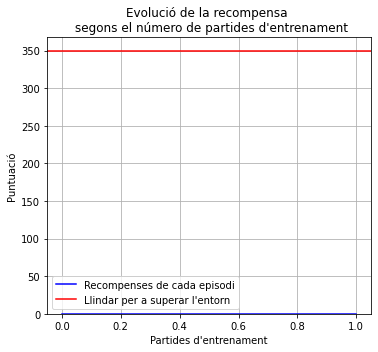

In [36]:
#dateLabel = "20221207124649 - " # Agent específic d'una execució concreta

reinforce_agent.dnnetwork.load_state_dict(torch.load("./models/{}agentReinforce_Trained_Model.pth".format(Label)))

# Definim una funció genèrica que execute diferents partides amb l'agent entrenat i salva l'últa partida per a usar en els següents apartats

games = 20
if quick_execution:
    games=2


def save_agent_n_games_reinforce(env, ag, games = 1):
    '''
    :param env:  entorn GYM
    :param ag:  agent entrenat
    :games: número de partides
    :return:
    :comentaris: Si s'indica un nom de fitxer es guarda la primera partida. En cas contrari, calcula la suma de recompenses per a cada episodi 
    i mostra en un gràfic la suma de les recompenses respecte dels episodis, incloent-hi el llindar de recompensa establert per l'entorn.
    '''
    
    # Guardem passes i recompenses
    total_score = np.empty(shape=(games), dtype=int)

    for i in range (games):
        env.reset()
        observation = env.reset()
        incio_juego = preprocess_observation(observation)
        state= stack_frame(None, incio_juego, True)
        total_reward = 0
        t=0
        while True:
                state= stack_frame(state, preprocess_observation(observation), False)
                action_probs = ag.dnnetwork.get_action_prob(state)  #distribució de probabilitat de les accions donat l'estat actual
                #print(action_probs)
                action = torch.max(action_probs, dim=-1)[1].item()    #acció aleatòria de la distribució de probabilitat
                #print ("Episode {}. Step {}. Action {}".format(i, t, action))
                observation, reward, done, info = env.step(action)
                total_reward += reward
                t=t+1
                if done:
                    break

        total_score[i] = total_reward
        #print("\rEpisode {:d} Rewards {:.2f} Frames {:d} Steps {:d}".format(i, total_reward, len(frames), t))

    env.close()
    
    # Generem el gràfic
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(range(len(total_score)), total_score, '-b', label='Recompenses de cada episodi')
    plt.axhline(y=350, color='r', linestyle='-', label="Llindar per a superar l'entorn")
    plt.xlabel("Partides d'entrenament")
    plt.ylabel("Puntuació")
    plt.ylim(bottom=0)
    plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament")
    plt.grid()
    plt.legend()
    plt.tight_layout()

# Funció per a jugar i enmagatzemar una partida en format GIF amb un agent entrenat
def save_agent_gif_reinforce(env, ag, nombre_fichero):
    '''
    :param env:  entorn GYM
    :param ag:  agent entrenat
    :param nombre_fichero:  nom del fitxer
    :return:
    '''
    frames = []
    env.reset()
    observation = env.reset()
    incio_juego = preprocess_observation(observation)
    state= stack_frame(None, incio_juego, True)
    total_reward = 0
    t=0
    while True:
            state= stack_frame(state, preprocess_observation(observation), False)
            frame = env.render(mode='rgb_array')
            frames.append(_label_with_text(frame))
            action_probs = ag.dnnetwork.get_action_prob(state)  #distribució de probabilitat de les accions donat l'estat actual
            #print(action_probs)
            action = torch.max(action_probs, dim=-1)[1].item()    #acció aleatòria de la distribució de probabilitat
            #print ("Episode {}. Step {}. Action {}".format(1, t, action))
            observation, reward, done, info = env.step(action)
            total_reward += reward
            t=t+1
            if done:
                break

    env.close()
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)



save_agent_n_games_reinforce(env, reinforce_agent, games=games)

env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
save_agent_gif_reinforce(env,reinforce_agent , 'agent_reinforce.gif')


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
</div>

## 5. Comparació de models (1 pt)
<p></p>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>5.1 Exercici (0.5 pts):</strong> Mostra en un mateix gràfic l'evolució de la mitjana de recompenses dels tres models juntament amb el llindar de recompensa.
</div>

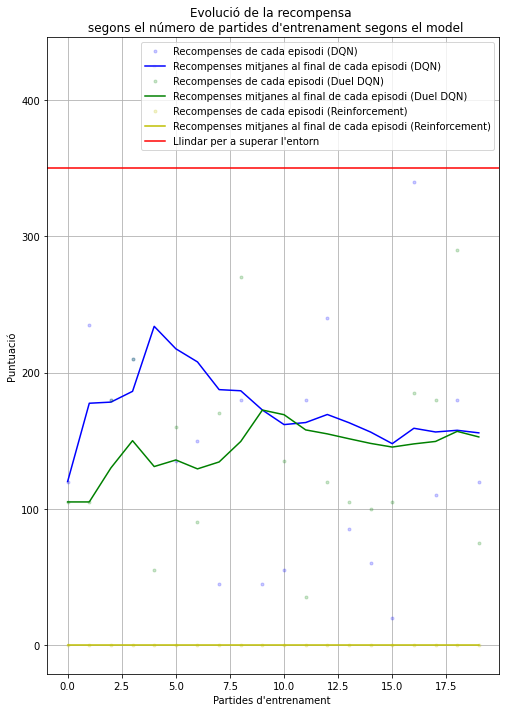

In [37]:
#Plots 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(range(len(agent.training_rewards)), agent.training_rewards, 'b.', label='Recompenses de cada episodi (DQN)', alpha=0.2)
plt.plot(range(len(agent.mean_training_rewards)), agent.mean_training_rewards, '-b', label='Recompenses mitjanes al final de cada episodi (DQN)')
plt.plot(range(len(agentDueling.training_rewards)), agentDueling.training_rewards, 'g.', label='Recompenses de cada episodi (Duel DQN)', alpha=0.2)
plt.plot(range(len(agentDueling.mean_training_rewards)), agentDueling.mean_training_rewards, '-g', label='Recompenses mitjanes al final de cada episodi (Duel DQN)')
plt.plot(range(len(reinforce_agent.training_rewards)), reinforce_agent.training_rewards, 'y.', label='Recompenses de cada episodi (Reinforcement)', alpha=0.2)
plt.plot(range(len(reinforce_agent.mean_training_rewards)), reinforce_agent.mean_training_rewards, '-y', label='Recompenses mitjanes al final de cada episodi (Reinforcement)')
plt.axhline(y=agentDueling.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
plt.xlabel("Partides d'entrenament ")
plt.ylabel("Puntuació")
plt.title("Evolució de la recompensa \n segons el número de partides d'entrenament segons el model")
plt.grid()
plt.legend()
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>5.2 Anàlisi (0.5 pts):</strong> Analitzar els resultats obtinguts tenint en compte el nombre depisodis, el temps dentrenament i el rendiment dels tres agents entrenats observat en apartats anteriors. Quin agent presenta un comportament millor? Per què?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br>Malauradament els models implementats per a Dueling DQN i Reinforcement sembla que no soncorrectes. El Dueling DQN no té un rendiment millor que DQN com seria d'esperar mentre que el model de reinforcement amb línia base directament no aprèn.<br>
</div>

## 6. Optimizació (1 pto)

En aquest apartat volem trobar la millor arquitectura i hiperparàmetres per optimitzar la precisió del model. Els punts que volem tenir en compte per a la cerca del millor model són els següents:
<ul>
     <li>Nombre d'unitats de les capes</li>
     <li>Learning rate</li>
     <li>Actualització de la xarxa principal</li>
     <li>Sincronització de la xarxa objectiu</li>
     <li>Batch size</li>
     <li>Gamma</li>
     <li>Nombre de partides de l'entrenament</li>
<ul>

Podeu modificar o adaptar la configuració com considereu oportú sempre que justifiqueu el benefici i el canvi.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>6.1 Exercici (1 pt):</strong> Triar un dels dos models de DQN implementats (DQN o dueling DQN) i experimentar amb diferents combinacions de valors per als paràmetres especificats. L'objectiu és aconseguir un model amb millors resultats que el presentat a la PAC. <b>Indicar</b> les proves realitzades, però presentar <b>únicament</b> l'execució i els resultats de la millor opció. Justificar els valors escollits d'hiperparàmetres per a les diferents proves realitzades i comentar els resultats d'entrenament i rendiment de l'agent entrenat.
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solució (Comentaris):</strong>
<br> He triat el model DQN ja que els altres models no els tenia ben implementats després de moltes hores de dedicació de manera que he preferit usar el model que tenia ben implementat<br>
<br>Farem una cerca en reixeta amb els següents hiperparàmetres intentant que el model après sigui una mica més complex que simplemetn quedar-se quiet i disparar:
<ul>
     <li>Nombre d'unitats de les capes</li>
     <li>Learning rate: Provarem amb els següents rangs: [0.01, 0.001, 0.0001]</li>
     <li>Actualització de la xarxa principal: Amb l'aprenentatge multipàs accelerem l'aprenentatge però podem perdre informació rellevant de manera que reduirem el paràmetre a [5, 25, 100]</li>
     <li>Sincronització de la xarxa objectiu: Proposem fer-ho amb els següents valors [1000, 2000, 5000]</li>
     <li>Batch size</li>
     <li>Gamma</li>
     <li>Nombre de partides de l'entrenament: Fixades a 1.500 ja que amb el model DQN no veiem evolució a partir d'aquest nombre en la gràfica de recompenses i epsilon ja ha arribat al mínim.</li>
<ul>
</br>
</div>

E20221217183839 - EP1500-LR0.01-MP5-SYN1000
E20221217183839 - EP1500-LR0.01-MP5-SYN2000
E20221217183839 - EP1500-LR0.01-MP5-SYN5000
E20221217183839 - EP1500-LR0.01-MP25-SYN1000
E20221217183839 - EP1500-LR0.01-MP25-SYN2000
E20221217183839 - EP1500-LR0.01-MP25-SYN5000
E20221217183839 - EP1500-LR0.01-MP100-SYN1000
E20221217183839 - EP1500-LR0.01-MP100-SYN2000
E20221217183839 - EP1500-LR0.01-MP100-SYN5000
E20221217183839 - EP1500-LR0.001-MP5-SYN1000
E20221217183839 - EP1500-LR0.001-MP5-SYN2000
E20221217183839 - EP1500-LR0.001-MP5-SYN5000
E20221217183839 - EP1500-LR0.001-MP25-SYN1000
E20221217183839 - EP1500-LR0.001-MP25-SYN2000
E20221217183839 - EP1500-LR0.001-MP25-SYN5000
E20221217183839 - EP1500-LR0.001-MP100-SYN1000
E20221217183839 - EP1500-LR0.001-MP100-SYN2000
E20221217183839 - EP1500-LR0.001-MP100-SYN5000
E20221217183839 - EP1500-LR0.0001-MP5-SYN1000
E20221217183839 - EP1500-LR0.0001-MP5-SYN2000
E20221217183839 - EP1500-LR0.0001-MP5-SYN5000
E20221217183839 - EP1500-LR0.0001-MP25-SYN1

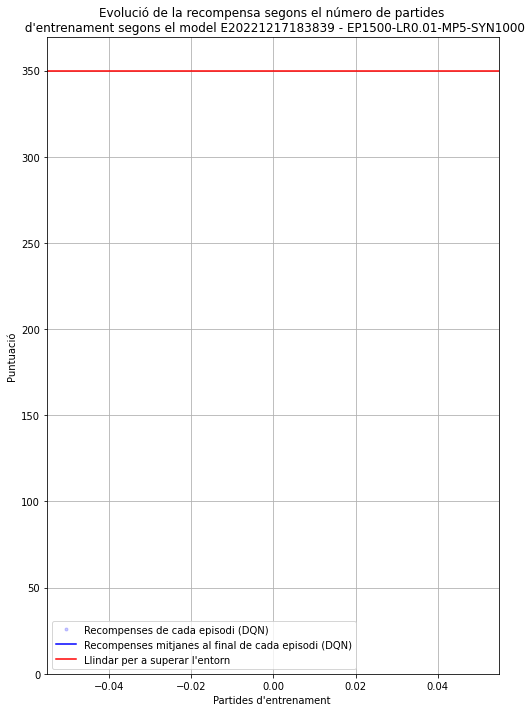

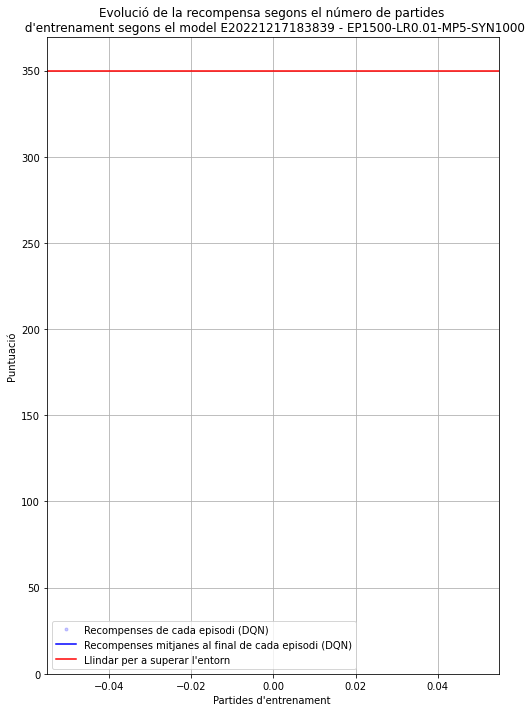

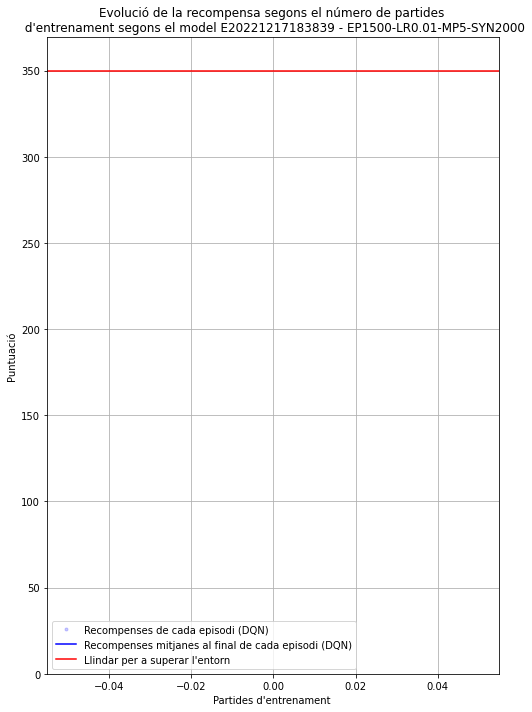

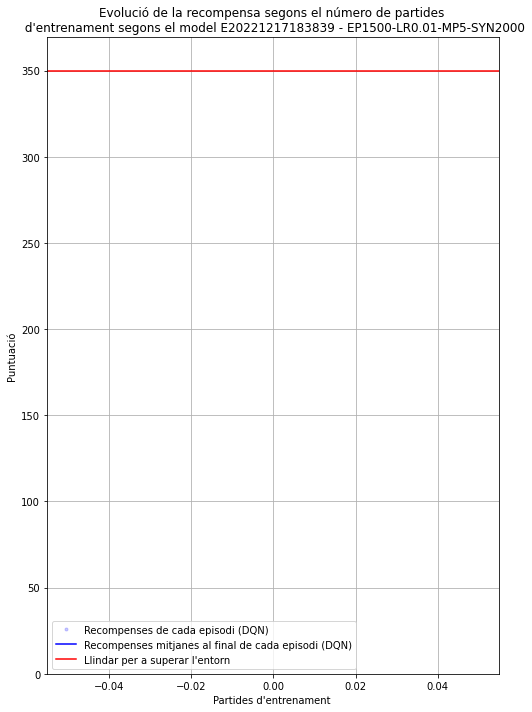

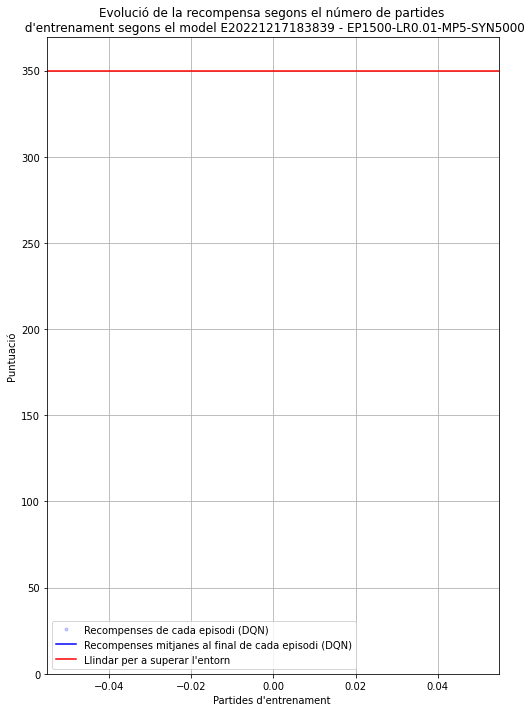

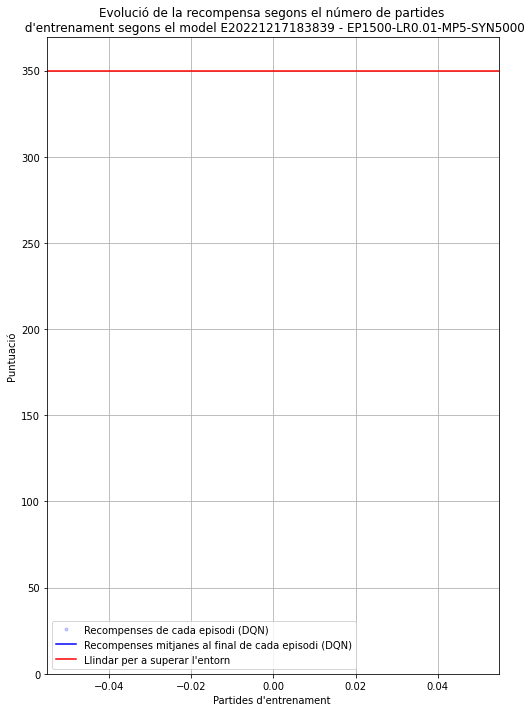

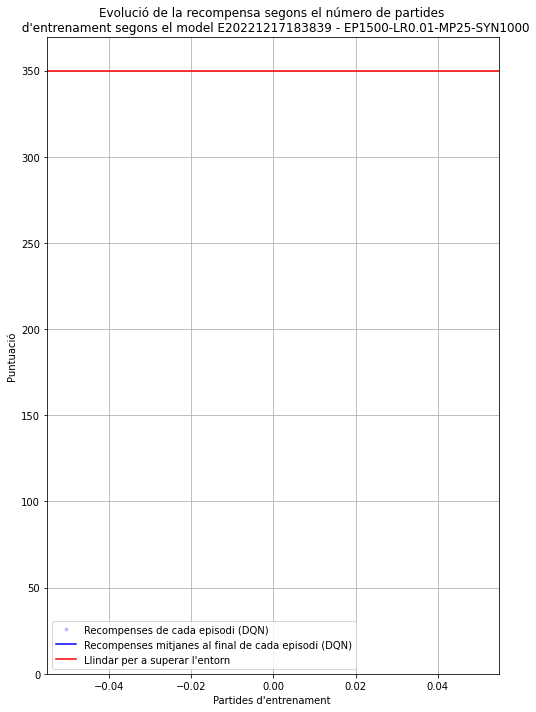

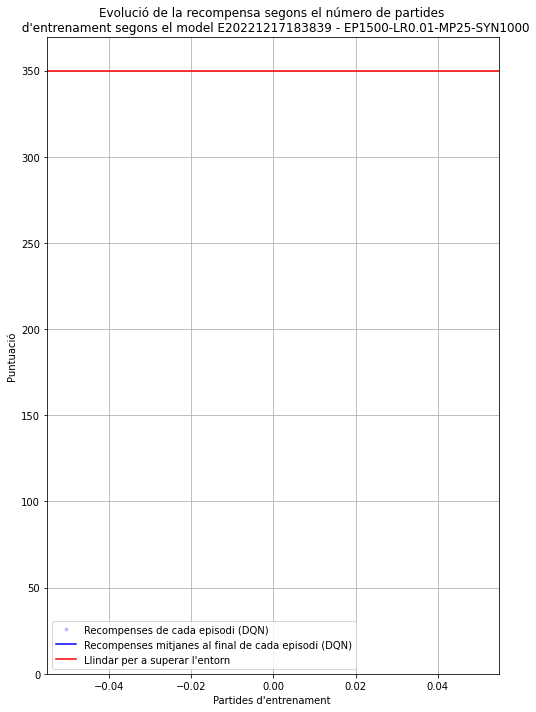

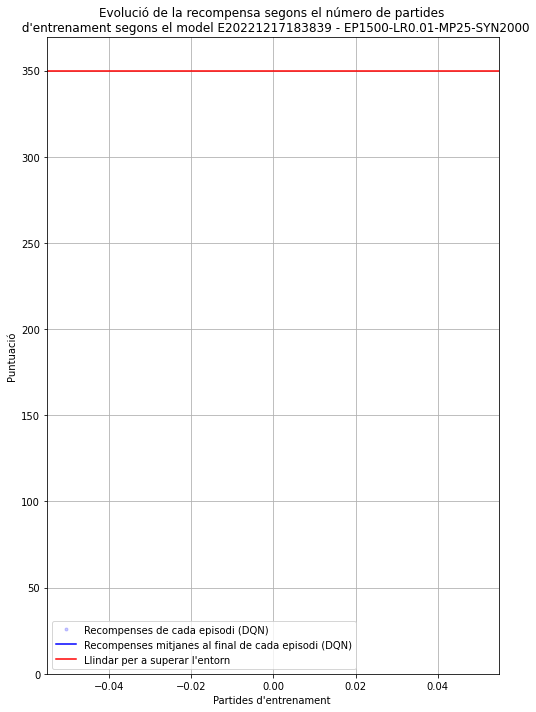

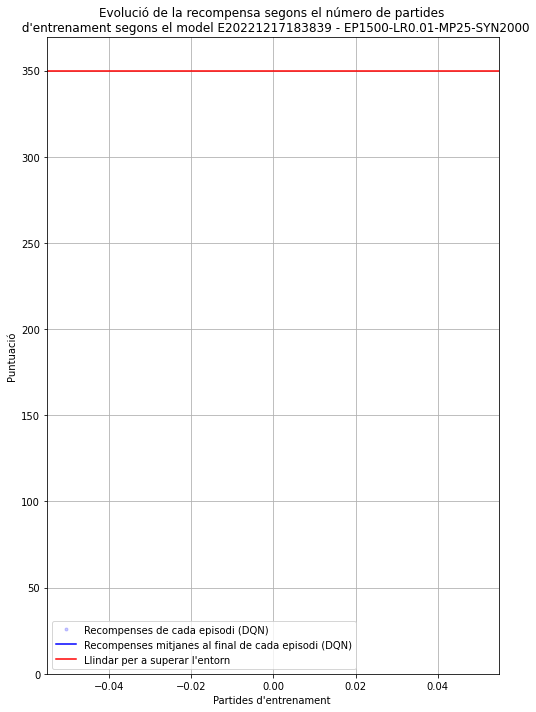

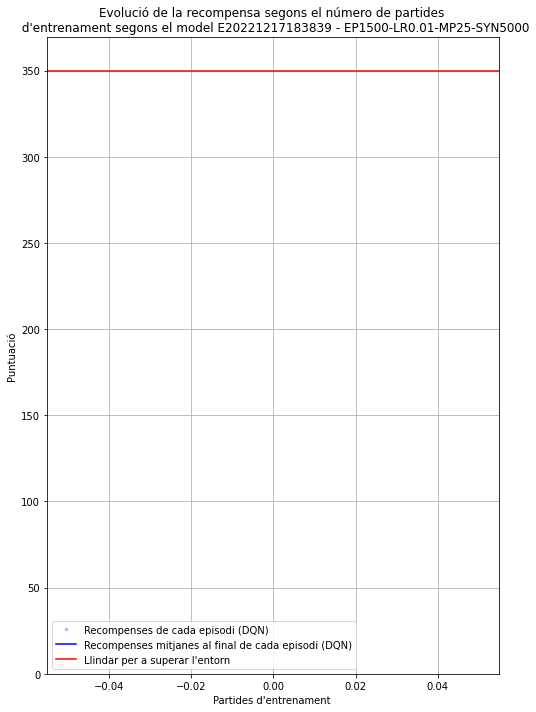

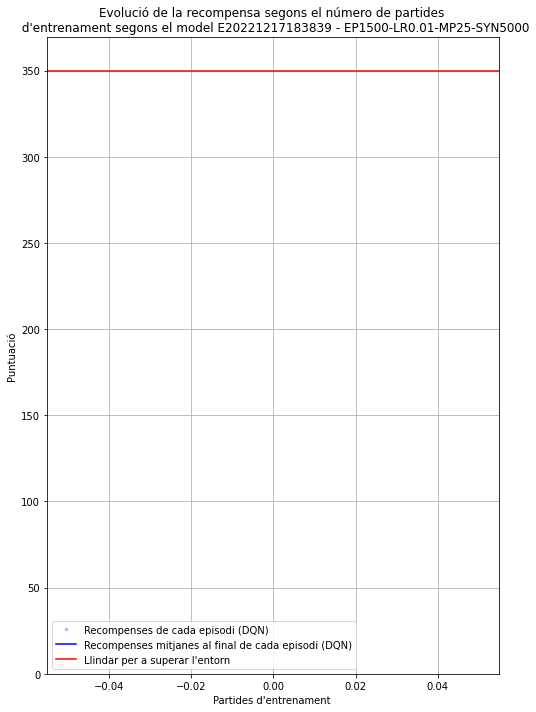

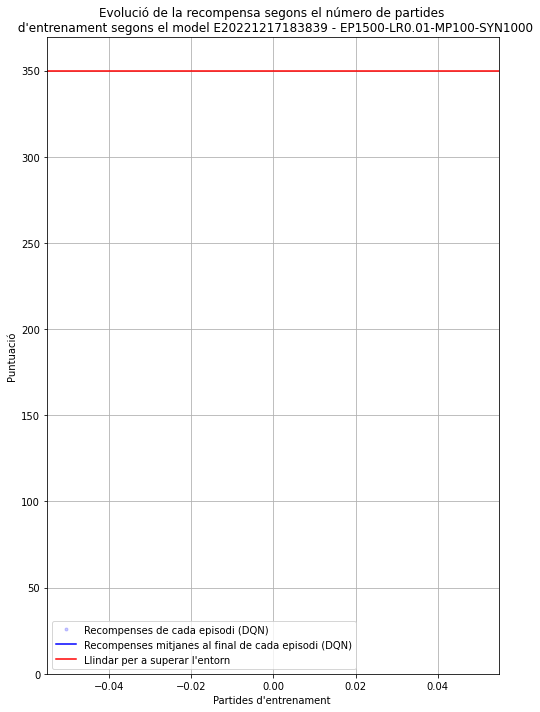

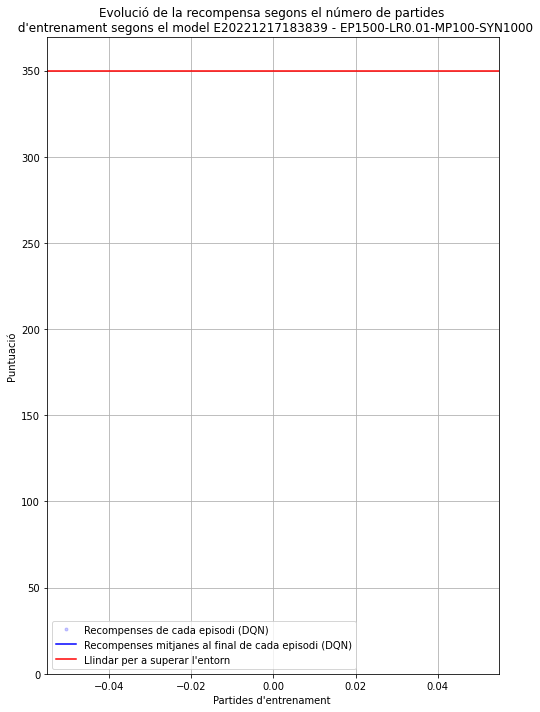

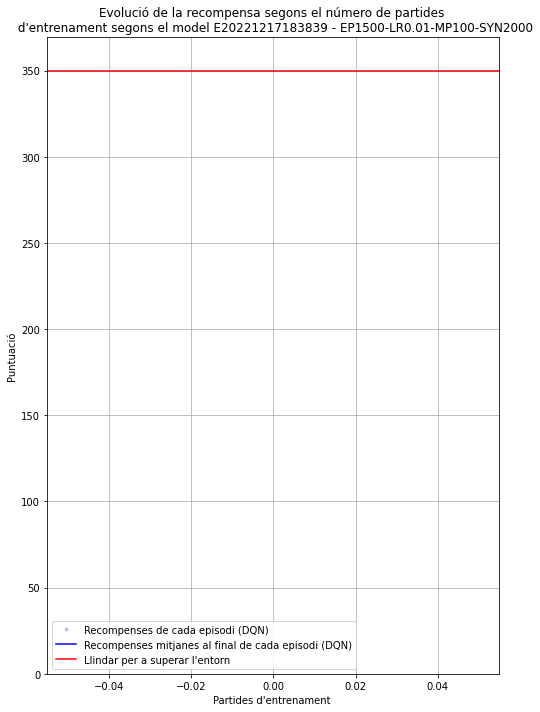

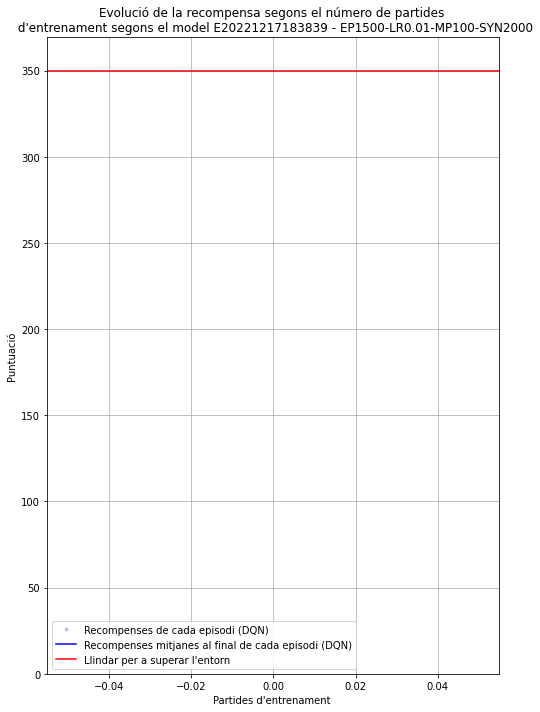

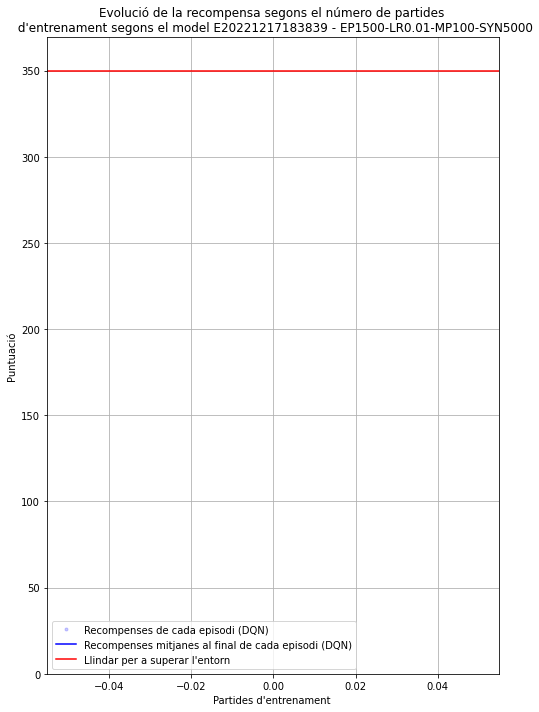

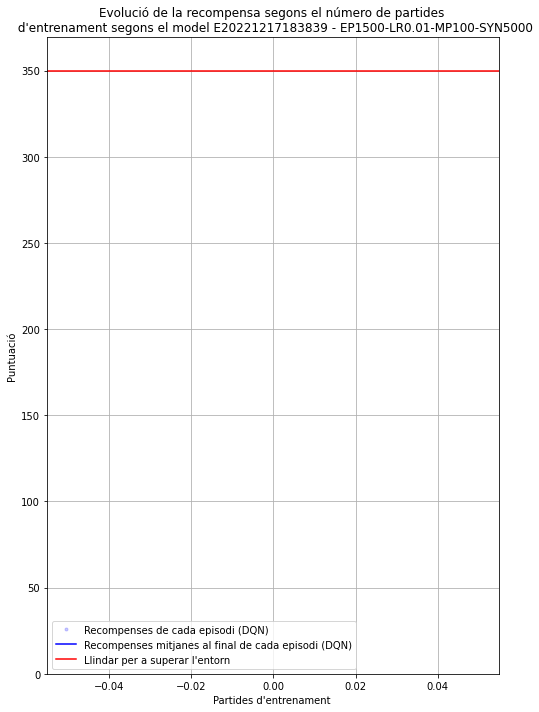

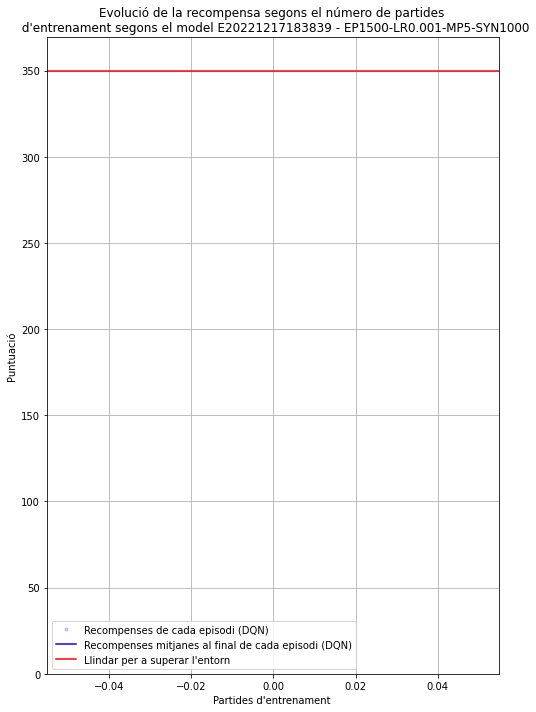

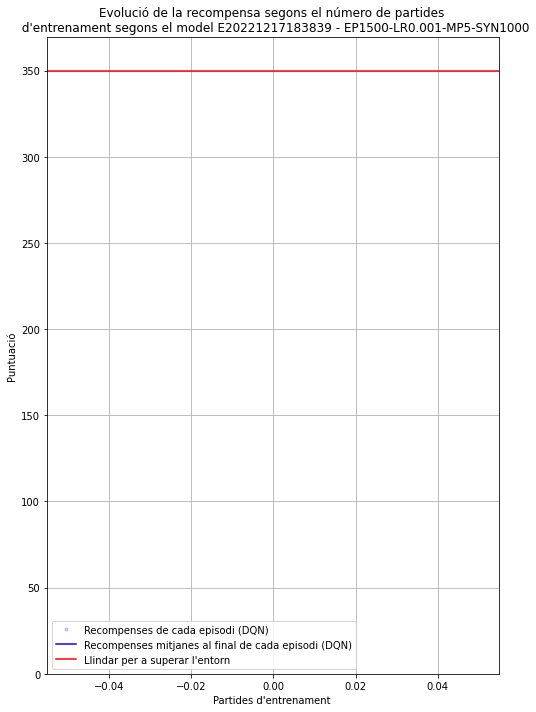

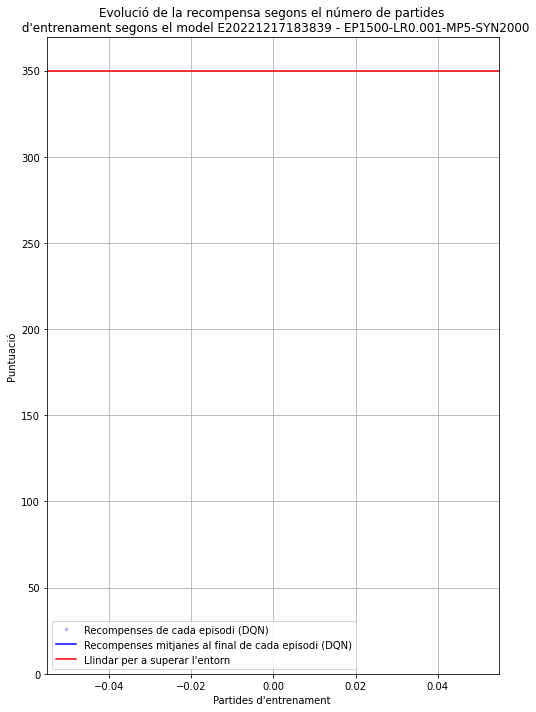

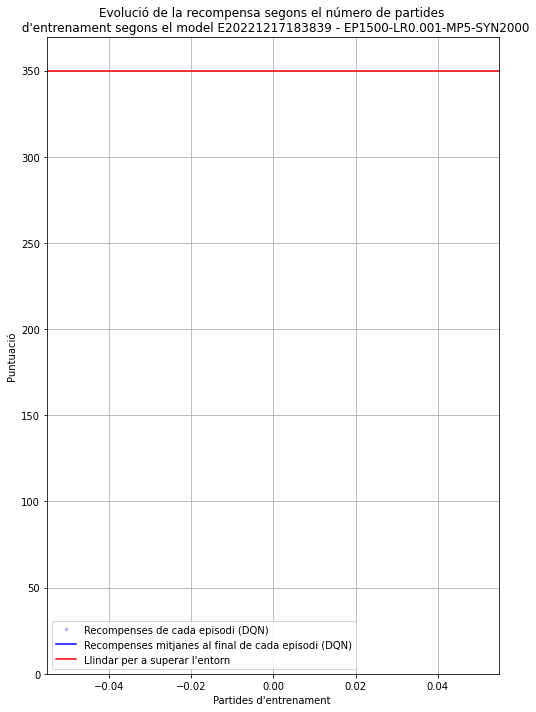

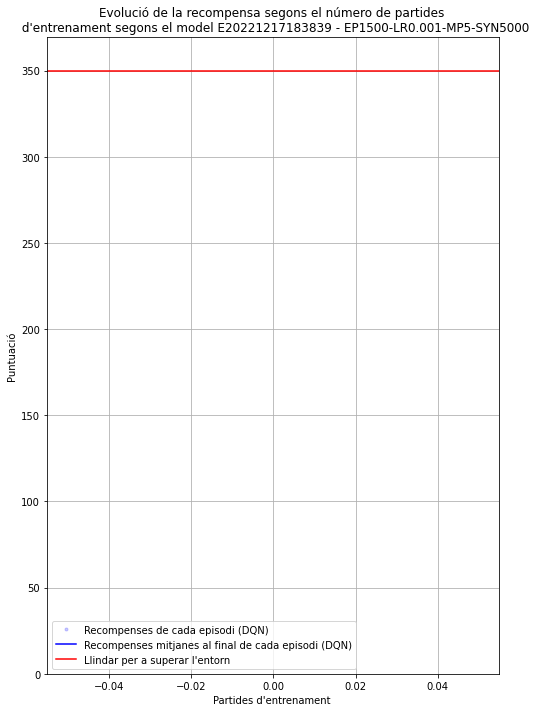

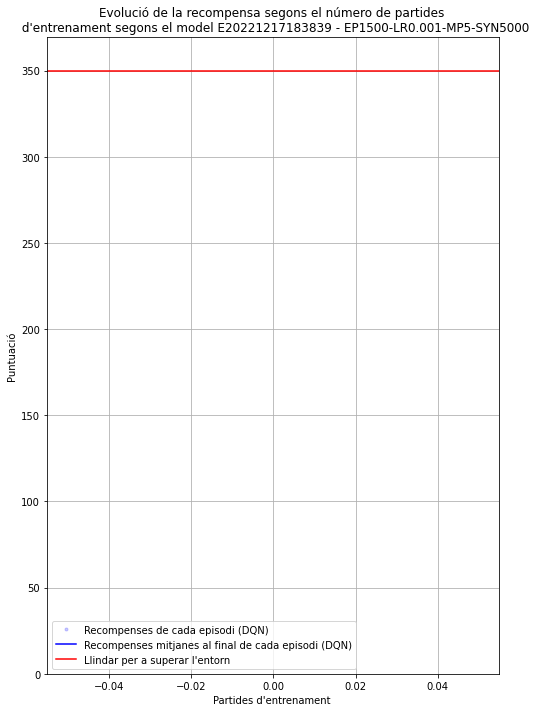

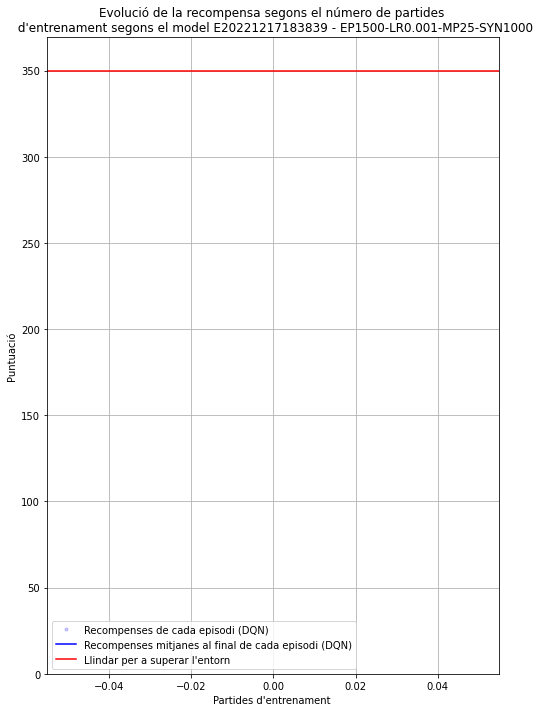

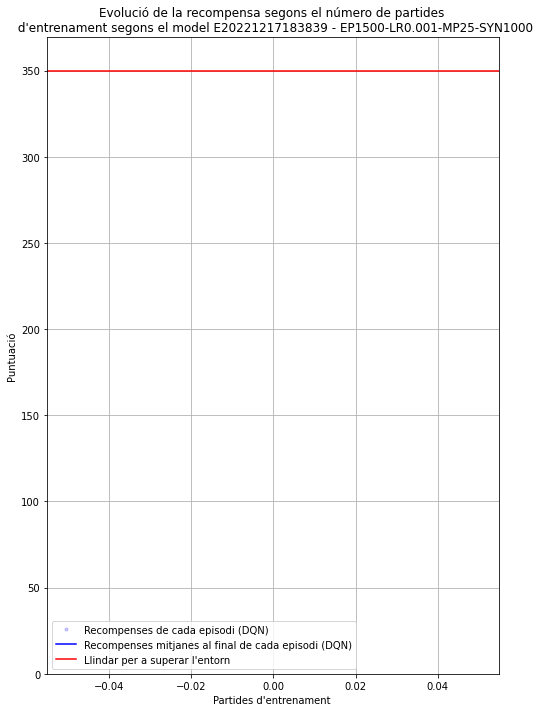

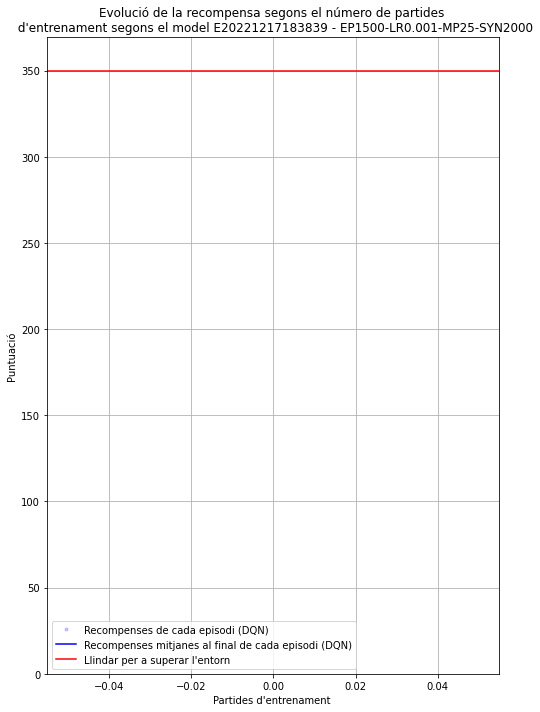

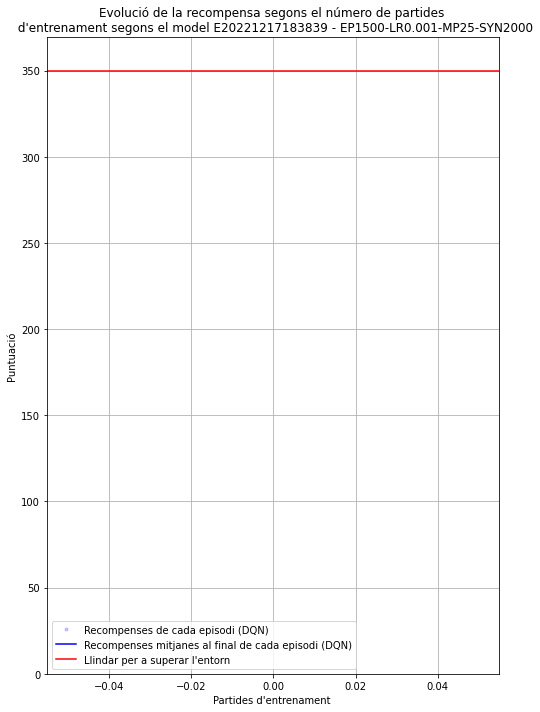

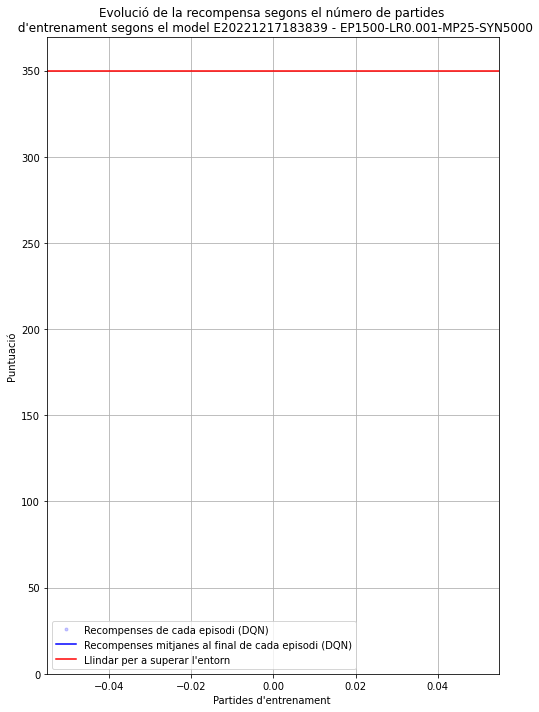

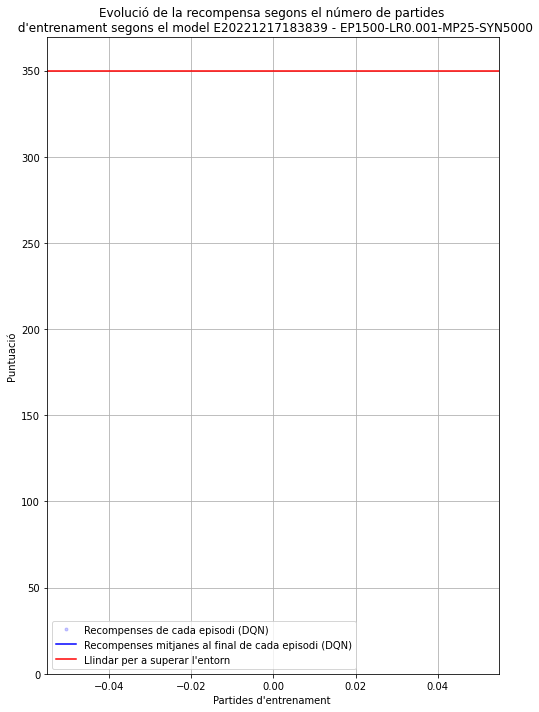

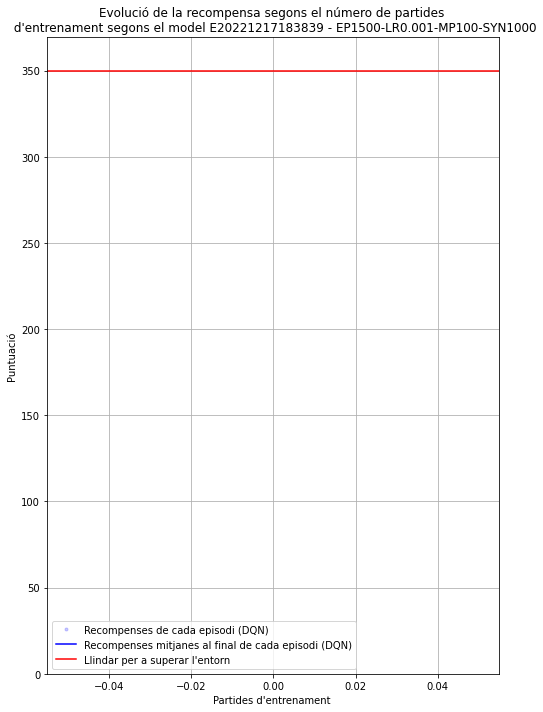

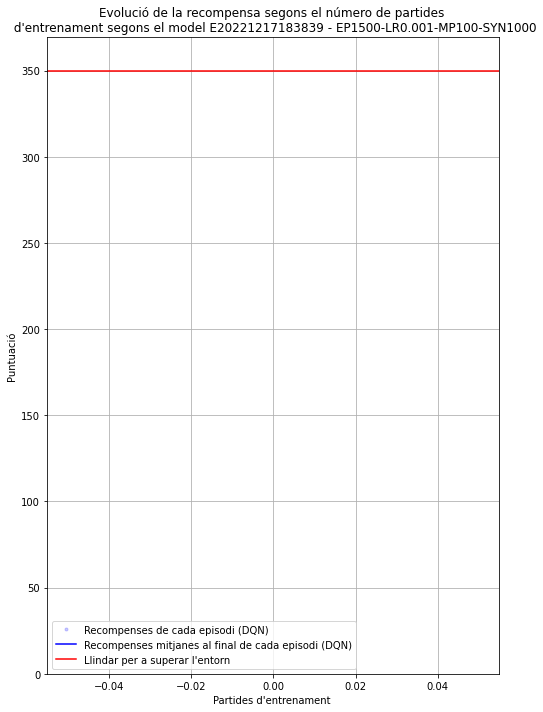

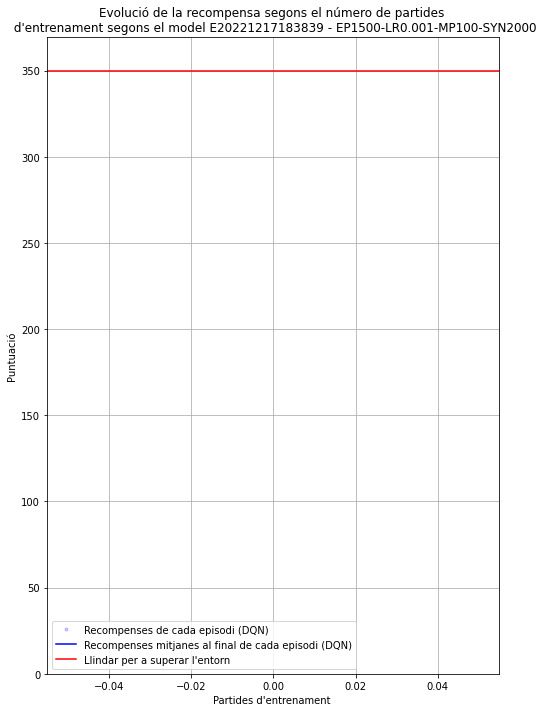

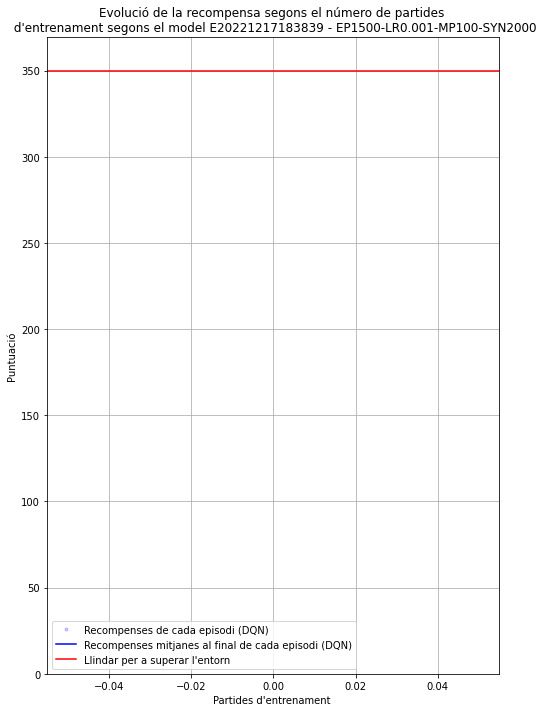

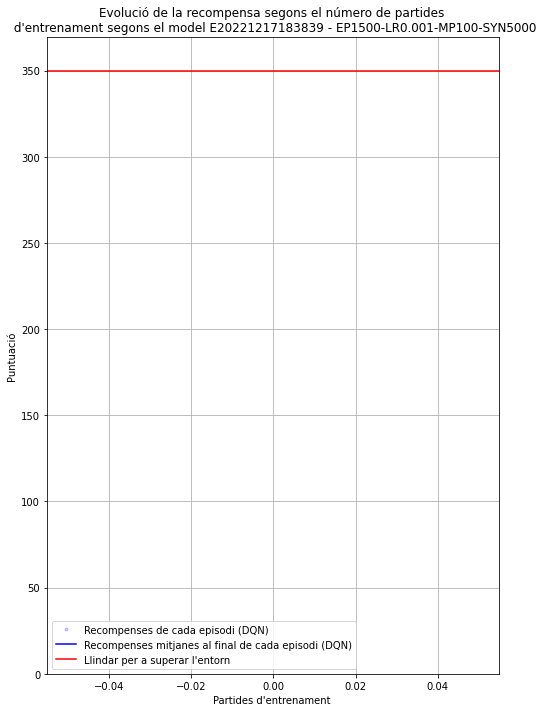

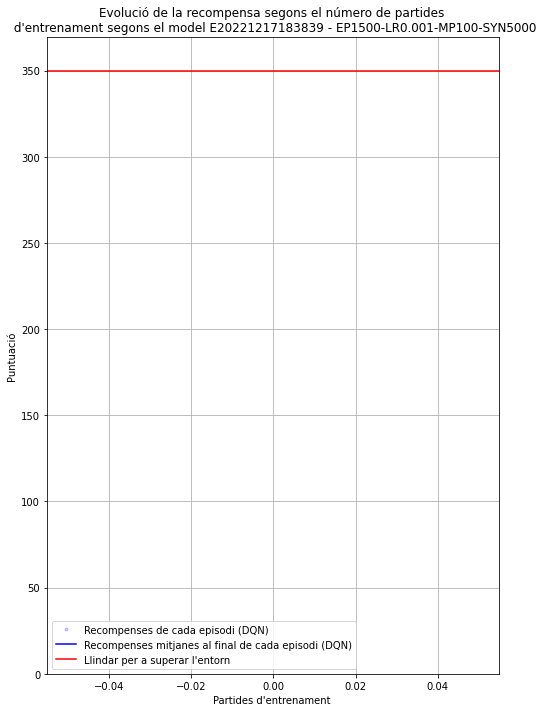

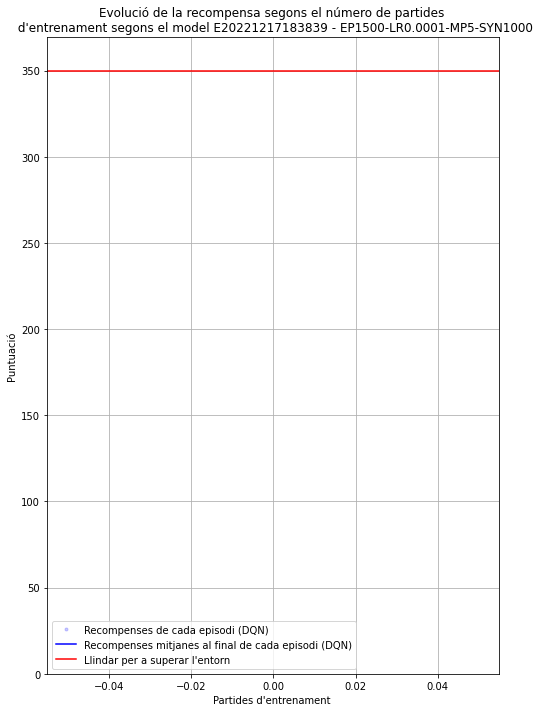

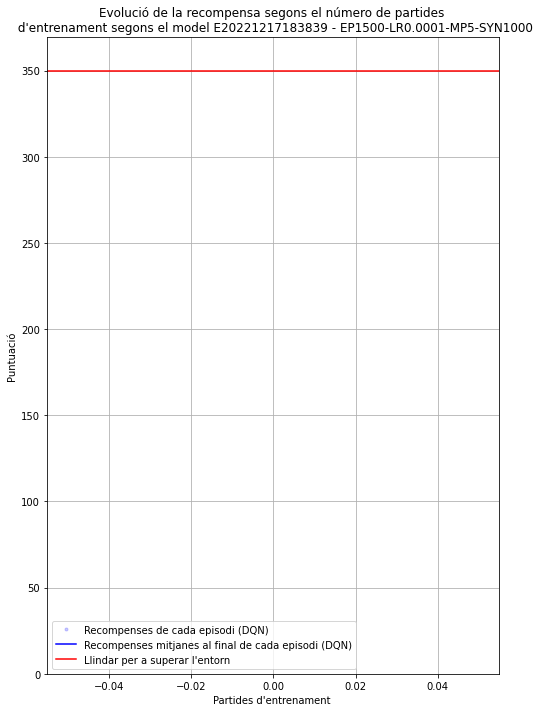

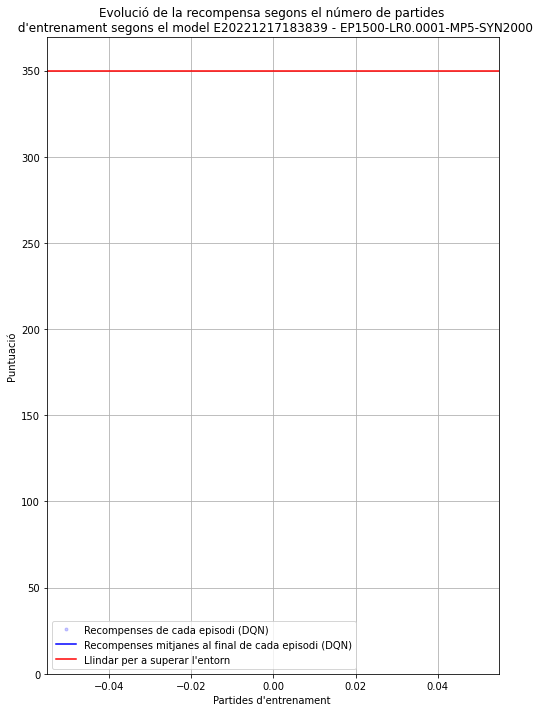

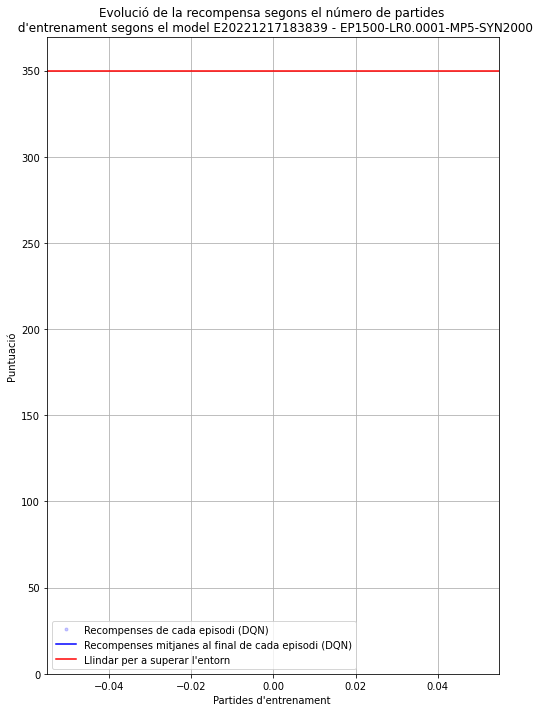

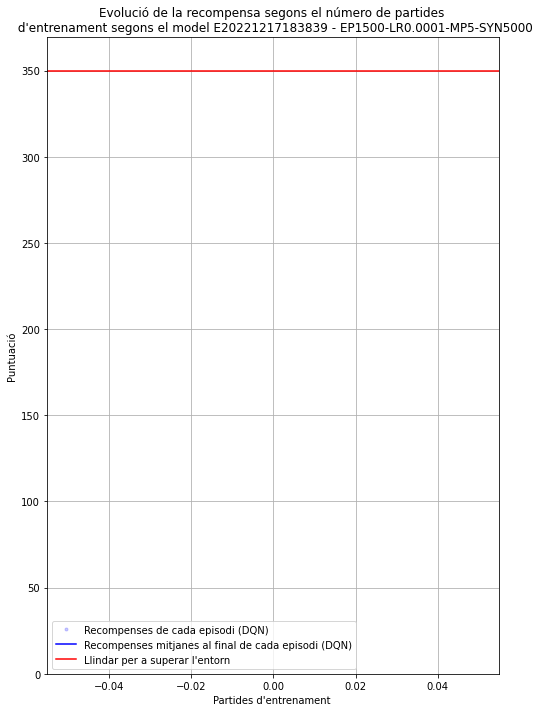

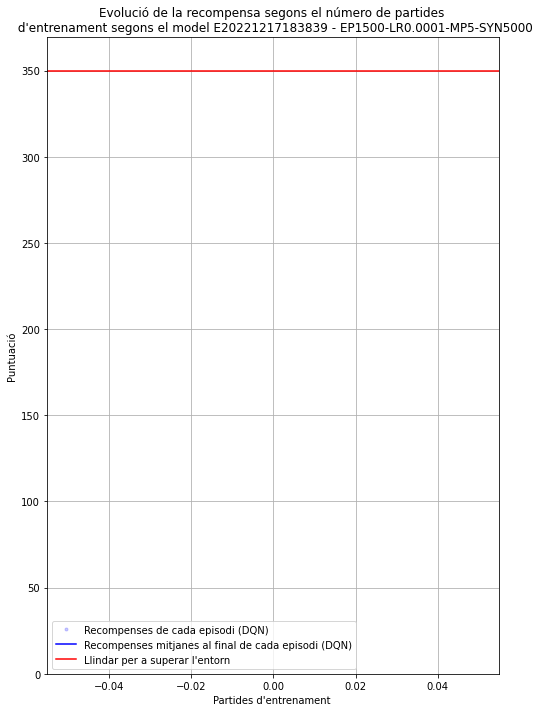

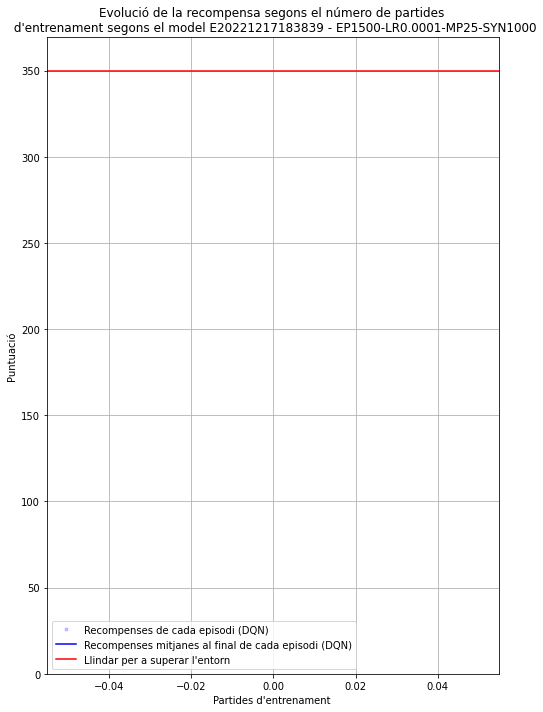

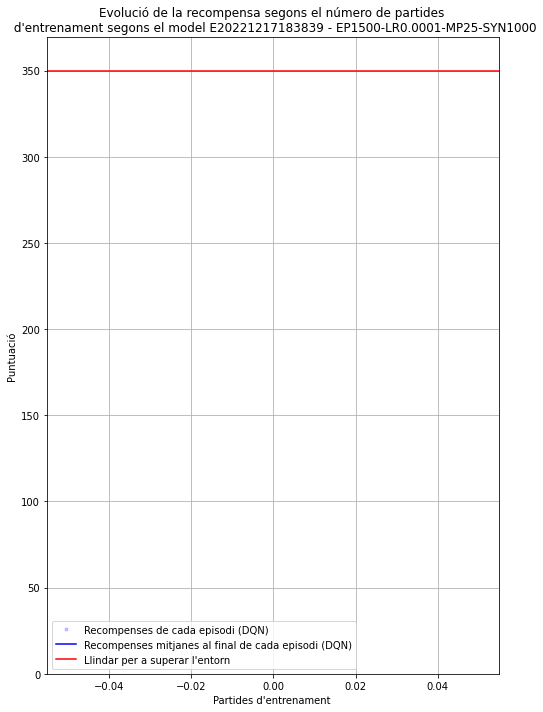

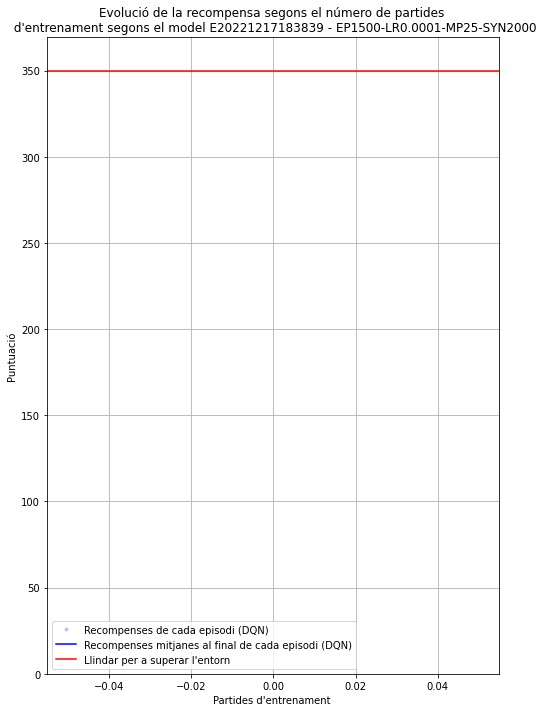

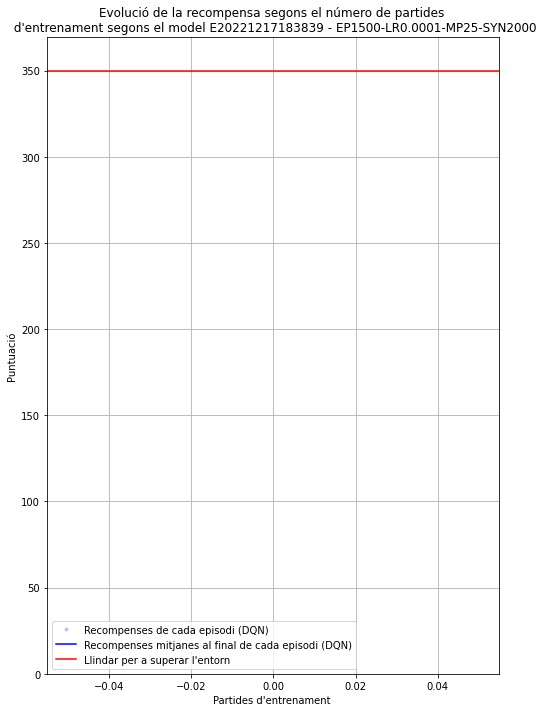

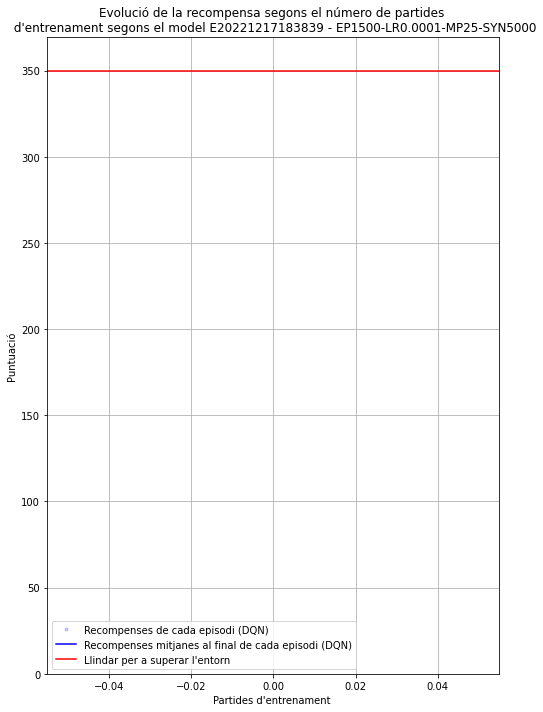

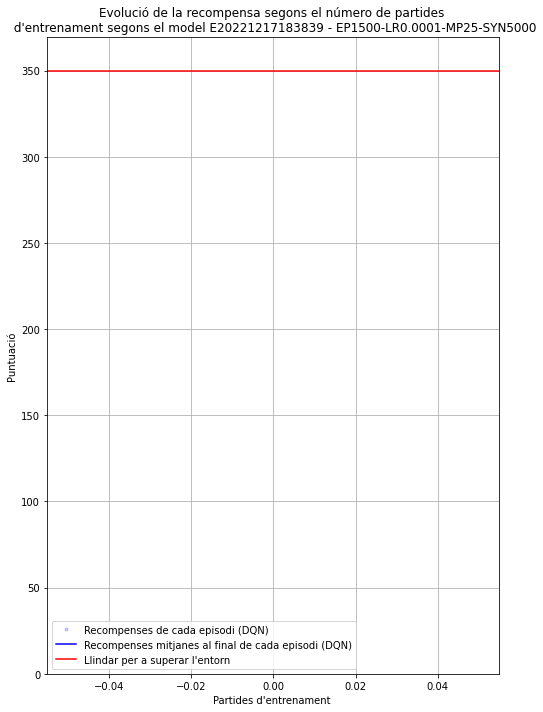

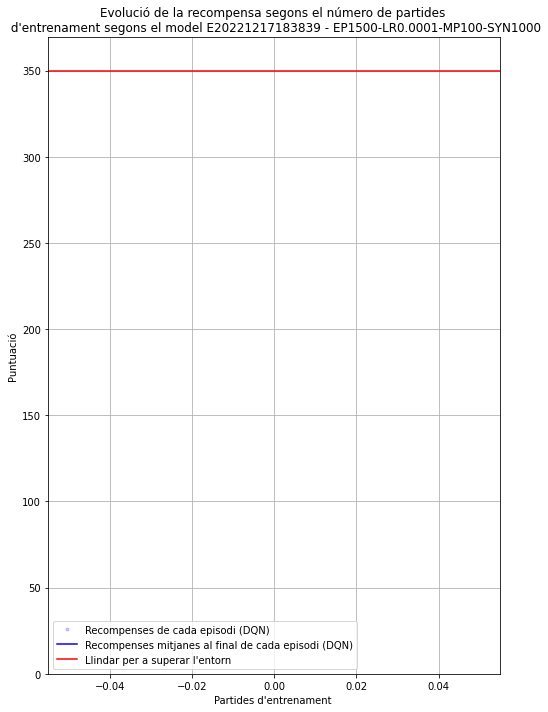

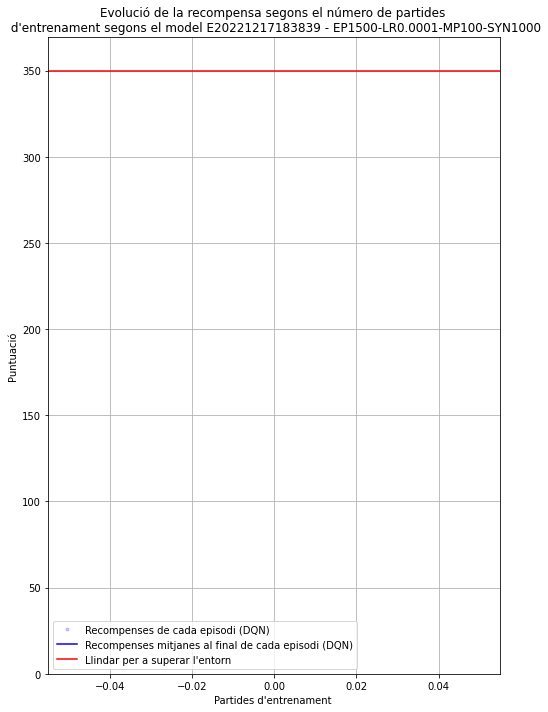

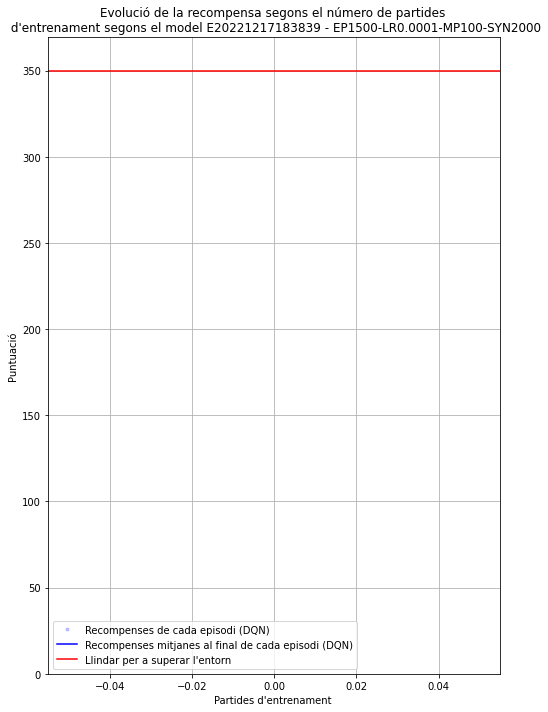

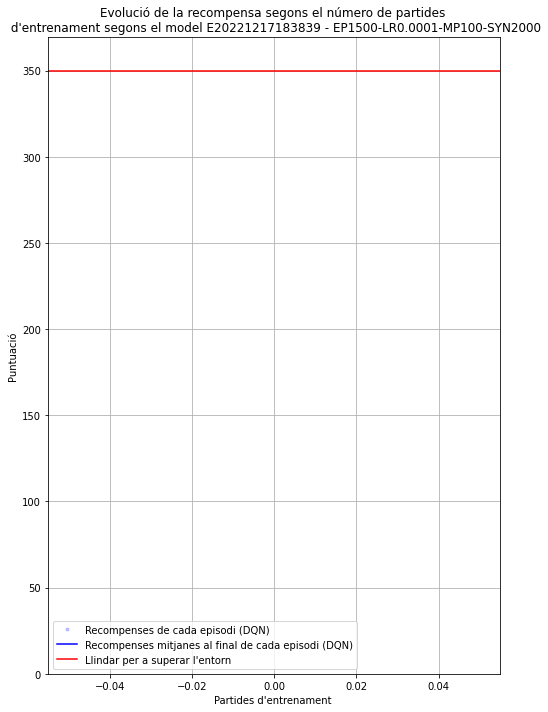

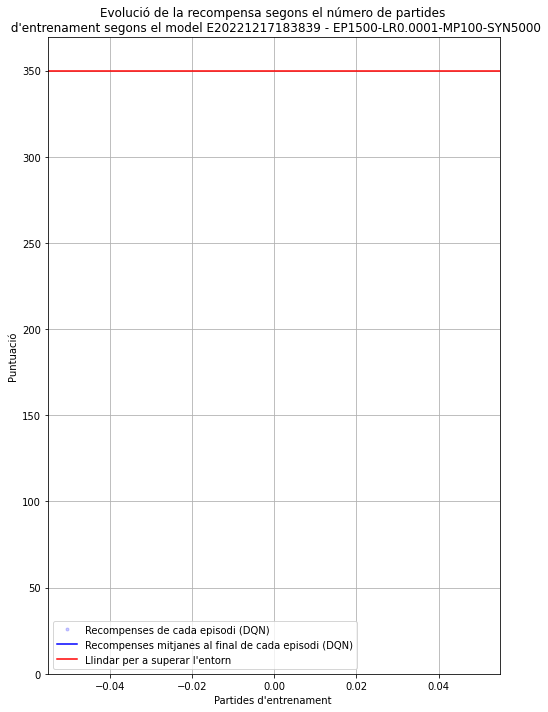

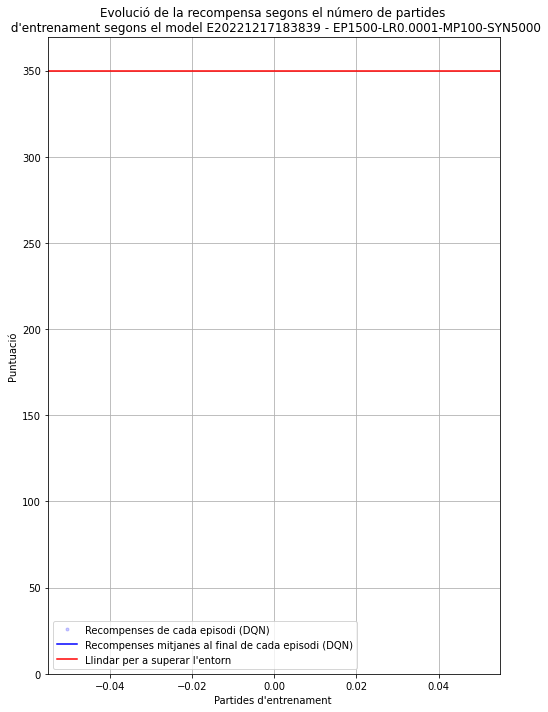

In [38]:
def DQN_Grid_Search(MAX_EPISODES, lr, DNN_UPD, DNN_SYNC):
    #lr = 0.001 #0.001            #Velocitat d'aprenentatge (alpha)
    BATCH_SIZE = 32 #32       #Conjunt a agafar del buffer per a la xarxa neuronal
    MEMORY_SIZE = 8000 #8000   #Màxima capacitat del buffer
    GAMMA = 0.99 #0.99         #Valor gamma de l'equació de Bellman
    EPSILON = 1 #1           #Valor inicial d'epsilon
    BURN_IN = 100 #100        #Nombre d'episodis inicials usats per emplenar el buffer abans d'entrenar
    #MAX_EPISODES = #5000 #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
    MIN_EPISODES = 0 #250    #Nombre mñinim d'episodis (l'agent ha d'acabar daprendre després d'arribar a aquest valor)
    EPSILON_DECAY = .995 #0.995 #Decaïment d'epsilon
    #DNN_UPD = 100       #Freqüència d'actualització de la xarxa neuronal 
    #DNN_SYNC = 5000 #5000      #Freqüència de sincronització de pesos entre la xarxa neuronal i la xarxa objectiu

    # tag de la parametrització
    tag = "{}EP{}-LR{}-MP{}-SYN{}".format(Label,MAX_EPISODES, lr, DNN_UPD, DNN_SYNC)
    print(tag)

    buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

    dqn = DQN_CNN(env, learning_rate=lr)

    agent = DQNAgent(env, main_network=dqn, buffer=buffer, reward_threshold=350, epsilon=EPSILON, eps_decay=EPSILON_DECAY, batch_size=BATCH_SIZE, nblock=100)

    if execute_optimization:
        agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, min_episodios=MIN_EPISODES)


    
    # Guardem el model sencer
    torch.save(rnet, "./models/{}agentDQN_Trained_Model_dqn_cnn-FULL.pth".format(tag))

    # Guardem els pesos
    torch.save(rnet.state_dict(), "./models/{}agentDQN_Trained_Model_dqn_cnn.pth".format(tag))

    # Salvem agent i els seus arrays de rewards
    np.savetxt("./models/{}agentDQN_Trained_Model_dqn_cnn-MeanRewards.txt".format(tag), agent.mean_training_rewards, fmt='%d')
    np.savetxt("./models/{}agentDQN_Trained_Model_dqn_cnn-Rewards.txt".format(tag), agent.training_rewards, fmt='%d')

    #Plots 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(range(len(agent.training_rewards)), agent.training_rewards, 'b.', label='Recompenses de cada episodi (DQN)', alpha=0.2)
    plt.plot(range(len(agent.mean_training_rewards)), agent.mean_training_rewards, '-b', label='Recompenses mitjanes al final de cada episodi (DQN)')
    plt.axhline(y=reinforce_agent.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
    plt.xlabel("Partides d'entrenament ")
    plt.ylabel("Puntuació")
    plt.ylim(0)
    plt.title("Evolució de la recompensa segons el número de partides \n d'entrenament segons el model " + tag)
    plt.grid()
    plt.legend()
    plt.tight_layout()

    # Preparem el plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(range(len(agent.training_rewards)), agent.training_rewards, 'b.', label='Recompenses de cada episodi (DQN)', alpha=0.2)
    plt.plot(range(len(agent.mean_training_rewards)), agent.mean_training_rewards, '-b', label='Recompenses mitjanes al final de cada episodi (DQN)')
    plt.axhline(y=reinforce_agent.reward_threshold, color='r', linestyle='-', label="Llindar per a superar l'entorn")
    plt.xlabel("Partides d'entrenament ")
    plt.ylabel("Puntuació")
    plt.ylim(0)
    plt.title("Evolució de la recompensa segons el número de partides \n d'entrenament segons el model " + tag)
    plt.grid()
    plt.legend()
    plt.tight_layout()

for MAX_EPISODES in [1500]:
    for lr in [0.01, 0.001, 0.0001]:
        for DNN_UPD in [5, 25, 100]:
            for DNN_SYNC in [1000, 2000, 5000]:
                DQN_Grid_Search(MAX_EPISODES, lr, DNN_UPD, DNN_SYNC)